In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import random
import statistics

In [2]:

pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",250)
pd.set_option('display.max_colwidth',None)

**Fonction Last_value**  
Cette fonction donne la derniere valeur disponible pour chaque pays, ici donne la derniere année disponible non NaN

In [3]:
def last_value(ind,option=0):
    if(option==0):
        ind=ind.drop(['Country Code', 'Indicator Name','Indicator Code', 'Topic','Region', 'Income Group'], axis=1)
    else:
        ind=ind.drop(['Country Code', 'Indicator Name','Indicator Code'], axis=1)
    #complt_ind.reset_index(drop=True)
    #Cherche le dernier index
    last_index=pd.DataFrame(ind.T).apply(pd.Series.last_valid_index)
    last_index.name="last_i"
    last_index=last_index.to_frame()
    last_index.dropna(axis=0, inplace=True)
    last_index["last_v"]=last_index.apply(lambda x: ind.loc[x.name,x.values], axis=1, result_type='broadcast')
    return last_index

## Synthetic Note

#### 5 Datasets :
    - EdStatsCountry : Informations sur le pays (général et economique)
    - EdStatsCountry-Series : Listing des codes SeriePays =>indicateur lié au pays.
    - EdStatsData: Ensemble de données pour chaque code Serie (indicateur),par pays, de 1970 à 2100.
    - EdStatsFootNote: Listing des codes Series Educations => indicateur lié à l'education
    - EdStatsSeries : Informations sur chaque code Serie (source, description)

Shape  : EdStatsData => (886930, 70)

Nous allons principalement travailler avec le dataset EdStatsData, les autres datasets serviront de support pour ajouter des informations complémentaires par rapport au code Serie par exemple.
A travers un Data.describe(), on observe que les données présents peut varié enormement d'une année à un autre, avec une beaucoup de données au alentour de 10^4 .

A travers ce premier heatmap, j'observe que beaucoup de données sont manquantes, avec une périodicité reguliere tout les 5ans, une augmentation des données à partir des années 1990 jusqu'en 2015.

Un petit feature selection a été fait sur les dates, en recuperant uniquement les données avec un taux de NA<90% hormis 1999
=> Afin de garder une regularité entre les données c'est à dire une périodicité de 5ans à partir des années 1990 puis la totalité de données entre 2000 et 2015.
=>Possiblité de partir uniquement sur les données avec un taux de NA<=80% (=> resultant avec 3 valeur :2000,2005,2010).

Je decide de récupere uniquement les pays ayant +20% de données => permettant d'avoir un petit filtrage des pays (notamment les non pays: World, Nord America qui sont hors scope).

A partir des analyses, on a obtenu 3665 indicateurs, toute ces indicateurs ne conclue pas forcement par des données concrets. j'ai donc décider de garder uniquement les indicateurs avec au moins 40% de données disponibles. 

Une fois, les deux filters misent ensemble, on se retrouve avec des données ayant seuelement 15% de NA , à défaut des 80% de NA.

Nous allons donc prendre le dataset avec ce filtrage afin de faire notre analyse.
J'observe à l'aide du Dataset EdStatsFootNote & du site web http://datatopics.worldbank.org/education/ qu'il existe une segmentation des indicateurs, il serait donc intéressant de les distinguer dans un premier temps pour ensuite les analyser.



### 1. Dataset EdStatsCountry

On découvre le contenu de chaque Dataset et son utilité

In [4]:
Country=pd.read_csv("Projet+Python_Dataset_Edstats_csv/EdStatsCountry.csv")

In [5]:
display(Country.head())

Country Code   Short Name   Table Name                     Long Name  \
0          ABW        Aruba        Aruba                         Aruba   
1          AFG  Afghanistan  Afghanistan  Islamic State of Afghanistan   
2          AGO       Angola       Angola   People's Republic of Angola   
3          ALB      Albania      Albania           Republic of Albania   
4          AND      Andorra      Andorra       Principality of Andorra   

  2-alpha code   Currency Unit  \
0           AW   Aruban florin   
1           AF  Afghan afghani   
2           AO  Angolan kwanza   
3           AL    Albanian lek   
4           AD            Euro   

                                                                                                                                                                                                                                       Special Notes  \
0                                                                                                      SNA data for 2000-2011 are updated from official government statistics; 1994-1999 from UN databases. Base year has changed from 1995 to 2000.   
1  Fiscal year end: March 20; reporting period for national accounts data: FY (from 2013 are CY). National accounts data are sourced from the IMF and differ from the Central Statistics Organization numbers due to exclusion of the opium economy.   
2                                                                                                                 April 2013 database update: Based on IMF data, national accounts data were revised for 2000 onward; the base year changed to 2002.   
3                                                                                                                                                                                                                                                NaN   
4                                                                                                                                                                                                                                                NaN   

                      Region          Income Group WB-2 code  \
0  Latin America & Caribbean  High income: nonOECD        AW   
1                 South Asia            Low income        AF   
2         Sub-Saharan Africa   Upper middle income        AO   
3      Europe & Central Asia   Upper middle income        AL   
4      Europe & Central Asia  High income: nonOECD        AD   

                          National accounts base year  \
0                                                2000   
1                                             2002/03   
2                                                2002   
3  Original chained constant price data are rescaled.   
4                                                1990   

   National accounts reference year                   SNA price valuation  \
0                               NaN     Value added at basic prices (VAB)   
1                               NaN     Value added at basic prices (VAB)   
2                               NaN  Value added at producer prices (VAP)   
3                            1996.0     Value added at basic prices (VAB)   
4                               NaN                                   NaN   

  Lending category Other groups  \
0              NaN          NaN   
1              IDA         HIPC   
2             IBRD          NaN   
3             IBRD          NaN   
4              NaN          NaN   

                                      System of National Accounts  \
0  Country uses the 1993 System of National Accounts methodology.   
1  Country uses the 1993 System of National Accounts methodology.   
2  Country uses the 1993 System of National Accounts methodology.   
3  Country uses the 1993 System of National Accounts methodology.   
4  Country uses the 1968 System of National Accounts methodology.   

  Alternative conversion factor PPP survey yea

In [6]:
#Country["Short Name"].unique()
#Country["Table Name"].unique()

In [7]:
#Country[Country["Short Name"]=="France"]

### 2. Dataset EdStatsCountry-Series

In [8]:
Country_Series=pd.read_csv("Projet+Python_Dataset_Edstats_csv/EdStatsCountry-Series.csv")

In [9]:
Country_Series.head(10)

CountryCode         SeriesCode  \
0         ABW        SP.POP.TOTL   
1         ABW        SP.POP.GROW   
2         AFG        SP.POP.GROW   
3         AFG  NY.GDP.PCAP.PP.CD   
4         AFG        SP.POP.TOTL   
5         AFG  NY.GDP.MKTP.PP.KD   
6         AFG  NY.GNP.MKTP.PP.CD   
7         AFG  NY.GDP.MKTP.PP.CD   
8         AFG  NY.GDP.PCAP.PP.KD   
9         AFG  NY.GNP.PCAP.PP.CD   

                                                DESCRIPTION  Unnamed: 3  
0  Data sources : United Nations World Population Prospects         NaN  
1   Data sources: United Nations World Population Prospects         NaN  
2   Data sources: United Nations World Population Prospects         NaN  
3                        Estimates are based on regression.         NaN  
4  Data sources : United Nations World Population Prospects         NaN  
5                        Estimates are based on regression.         NaN  
6                        Estimates are based on regression.         NaN  
7                        Estimates are based on regression.         NaN  
8                        Estimates are based on regression.         NaN  
9                        Estimates are based on regression.         NaN

In [10]:
#Country_Series["SeriesCode"].unique()

### 3. Dataset EdStatsData

In [11]:
Data=pd.read_csv("Projet+Python_Dataset_Edstats_csv/EdStatsData.csv")

In [12]:
Data.head()

Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   
3   Arab World          ARB   
4   Arab World          ARB   

                                                            Indicator Name  \
0             Adjusted net enrolment rate, lower secondary, both sexes (%)   
1                 Adjusted net enrolment rate, lower secondary, female (%)   
2  Adjusted net enrolment rate, lower secondary, gender parity index (GPI)   
3                   Adjusted net enrolment rate, lower secondary, male (%)   
4                     Adjusted net enrolment rate, primary, both sexes (%)   

   Indicator Code       1970       1971       1972       1973       1974  \
0      UIS.NERA.2        NaN        NaN        NaN        NaN        NaN   
1    UIS.NERA.2.F        NaN        NaN        NaN        NaN        NaN   
2  UIS.NERA.2.GPI        NaN        NaN        NaN        NaN        NaN   
3    UIS.NERA.2.M        NaN        NaN        NaN        NaN        NaN   
4     SE.PRM.TENR  54.822121  54.894138  56.209438  57.267109  57.991138   

       1975       1976      1977      1978       1979       1980       1981  \
0       NaN        NaN       NaN       NaN        NaN        NaN        NaN   
1       NaN        NaN       NaN       NaN        NaN        NaN        NaN   
2       NaN        NaN       NaN       NaN        NaN        NaN        NaN   
3       NaN        NaN       NaN       NaN        NaN        NaN        NaN   
4  59.36554  60.999962  61.92268  62.69342  64.383186  65.617767  66.085152   

        1982       1983       1984       1985       1986      1987       1988  \
0        NaN        NaN        NaN        NaN        NaN       NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN       NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN       NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN       NaN        NaN   
4  66.608139  67.290451  68.510094  69.033211  69.944908  71.04187  71.693779   

        1989       1990       1991       1992       1993       1994      1995  \
0        NaN        NaN        NaN        NaN        NaN        NaN       NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN       NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN       NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN       NaN   
4  71.699097  71.995819  72.602837  70.032722  70.464821  72.645683  71.81176   

        1996       1997       1998       1999       2000       2001  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4  73.903511  74.425201  75.110817  76.254318  77.245682  78.800522   

        2002       2003       2004       2005       2006       2007  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4  80.051399  80.805389  81.607063  82.489487  82.685509  83.280342   

        2008       2009       2010      2011       2012      2013       2014  \
0        NaN        NaN        NaN       NaN        NaN       NaN        NaN   
1        NaN        NaN        NaN       NaN        NaN       NaN        NaN   
2        NaN        NaN        NaN       NaN        NaN       NaN        NaN   
3        NaN        NaN        NaN       NaN        NaN       NaN        NaN   
4  84.011871  84.195961  85.211998  85.24514  86.101669  85.51194  85.320152   

   2015  2016  2017  2020  2025  2030  2035  2040  2045  2050  2055  2060  \
0   NaN   NaN   NaN   NaN   

In [13]:
#Taille du Dataset principal
Data.shape

(886930, 70)

In [14]:
#pd.pivot_table(Data, values=["1990","1995","2000","2005","2010","2011","2012","2013","2014","2015"], index=['Country Name'], columns=['Indicator Code'], aggfunc="count", margins=True)

### 4. Dataset EdStatsFootNote

In [15]:
Foot_Note=pd.read_csv("Projet+Python_Dataset_Edstats_csv/EdStatsFootNote.csv")

In [16]:
Foot_Note.head(10)

CountryCode         SeriesCode    Year          DESCRIPTION  Unnamed: 4
0         ABW     SE.PRE.ENRL.FE  YR2001  Country estimation.         NaN
1         ABW     SE.TER.TCHR.FE  YR2005  Country estimation.         NaN
2         ABW     SE.PRE.TCHR.FE  YR2000  Country estimation.         NaN
3         ABW     SE.SEC.ENRL.GC  YR2004  Country estimation.         NaN
4         ABW        SE.PRE.TCHR  YR2006  Country estimation.         NaN
5         ABW        SE.PRE.NENR  YR2000  Country estimation.         NaN
6         ABW  SE.SEC.ENRL.VO.FE  YR2005  Country estimation.         NaN
7         ABW     SE.SEC.ENRL.GC  YR2003  Country estimation.         NaN
8         ABW     SE.PRM.TCHR.FE  YR1999  Country estimation.         NaN
9         ABW  SE.PRE.TCHR.FE.ZS  YR2008  Country estimation.         NaN

In [17]:
#Foot_Note[Foot_Note["CountryCode"]=="FRA"]

### 5. Dataset EdStatsSeries

In [18]:
Series=pd.read_csv("Projet+Python_Dataset_Edstats_csv/EdStatsSeries.csv")

In [19]:
Series.head(10)

Series Code       Topic  \
0  BAR.NOED.1519.FE.ZS  Attainment   
1     BAR.NOED.1519.ZS  Attainment   
2  BAR.NOED.15UP.FE.ZS  Attainment   
3     BAR.NOED.15UP.ZS  Attainment   
4  BAR.NOED.2024.FE.ZS  Attainment   
5     BAR.NOED.2024.ZS  Attainment   
6  BAR.NOED.2529.FE.ZS  Attainment   
7     BAR.NOED.2529.ZS  Attainment   
8  BAR.NOED.25UP.FE.ZS  Attainment   
9     BAR.NOED.25UP.ZS  Attainment   

                                                           Indicator Name  \
0  Barro-Lee: Percentage of female population age 15-19 with no education   
1         Barro-Lee: Percentage of population age 15-19 with no education   
2    Barro-Lee: Percentage of female population age 15+ with no education   
3           Barro-Lee: Percentage of population age 15+ with no education   
4  Barro-Lee: Percentage of female population age 20-24 with no education   
5         Barro-Lee: Percentage of population age 20-24 with no education   
6  Barro-Lee: Percentage of female population age 25-29 with no education   
7         Barro-Lee: Percentage of population age 25-29 with no education   
8    Barro-Lee: Percentage of female population age 25+ with no education   
9           Barro-Lee: Percentage of population age 25+ with no education   

                                              Short definition  \
0  Percentage of female population age 15-19 with no education   
1         Percentage of population age 15-19 with no education   
2    Percentage of female population age 15+ with no education   
3           Percentage of population age 15+ with no education   
4  Percentage of female population age 20-24 with no education   
5         Percentage of population age 20-24 with no education   
6  Percentage of female population age 25-29 with no education   
7         Percentage of population age 25-29 with no education   
8    Percentage of female population age 25+ with no education   
9           Percentage of population age 25+ with no education   

                                               Long definition  \
0  Percentage of female population age 15-19 with no education   
1         Percentage of population age 15-19 with no education   
2    Percentage of female population age 15+ with no education   
3           Percentage of population age 15+ with no education   
4  Percentage of female population age 20-24 with no education   
5         Percentage of population age 20-24 with no education   
6  Percentage of female population age 25-29 with no education   
7         Percentage of population age 25-29 with no education   
8    Percentage of female population age 25+ with no education   
9           Percentage of population age 25+ with no education   

   Unit of measure Periodicity Base Period Other notes Aggregation method  \
0              NaN         NaN         NaN         NaN                NaN   
1              NaN         NaN         NaN         NaN                NaN   
2              NaN         NaN         NaN         NaN                NaN   
3              NaN         NaN         NaN         NaN                NaN   
4              NaN         NaN         NaN         NaN                NaN   
5              NaN         NaN         NaN         NaN                NaN   
6              NaN         NaN         NaN         NaN                NaN   
7              NaN         NaN         NaN         NaN                NaN   
8              NaN         NaN         NaN         NaN                NaN   
9              NaN         NaN         NaN         NaN                NaN   

  Limitations and exceptions  Notes from original source General comments  \
0                        NaN                         NaN              NaN   
1                        NaN                         NaN              NaN   
2                        NaN                         NaN              NaN   
3                        NaN                         NaN              NaN   
4                        NaN                         NaN 

In [20]:
#Series["Topic"].unique()

In [21]:
#Series[Series["Series Code"]=="SP.POP.GROW"]

In [22]:
Series.shape

(3665, 21)

## Start to clean & general analysis

On découvre le contenu du Dataset, la forme, les NaN, le pourcentage de données présents

**Pourcentage de NaN par années**

In [23]:
#(Data.isna()==True).sum()/Data.shape[0]

**Pourcentage de NaN par années ayant un taux élévé => Mis en place de filtre par années**

In [24]:
#(Data.isna().sum()/Data.shape[0]).sort_values()<=0.81

**Fonction Classique pour decouvrir le dataset et son fonctionnement**  

In [25]:
#Data[(Data["Country Code"]=="FRA") & (Data["Indicator Code"]=="SE.SEC.ENRL.TC.ZS")]

In [26]:
#Data[(Data["Indicator Code"]=="SP.POP.GROW")]

**Aperçu visuelle du Dataset**  
Une version visuelle est plus concret que des chiffres

In [27]:
#fig=plt.figure(figsize = (20,10))
#sns.heatmap(Data.isna(), cbar=False)

**Mis en place de nouveaux Dataset basé sur Data**  
  
Je n'ai pas supprimé les colonnes avec drop() pour faciliter la manipulation plus tard.  
Data_Clean_Country est le dataset qui va mettre en place le filter sur les pays.  
Data_Clean_IndicatorCode est le dataset qui va mettre en place le filter sur les indicateurs.  

In [28]:
#Data=Data[["Country Name","Country Code","Indicator Name","Indicator Code","1990","1995",
#      "2000","2001","2002","2003","2004","2005","2006","2007","2008","2009",
#     "2010","2011","2012","2013","2014","2015"]]

Data_Clean_Country=Data[["Country Name",#"Country Code","Indicator Name","Indicator Code",
           "1990", "1991", "1992", "1993", "1994","1995", "1996", "1997", "1998", "1999",
      "2000","2001","2002","2003","2004","2005","2006","2007","2008","2009",
     "2010","2011","2012","2013","2014","2015"]]

Data_Clean_IndicatorCode=Data[[#"Country Name",#"Country Code","Indicator Name",
            "Indicator Code",
            "1990", "1991", "1992", "1993", "1994","1995", "1996", "1997", "1998", "1999",
      "2000","2001","2002","2003","2004","2005","2006","2007","2008","2009",
     "2010","2011","2012","2013","2014","2015"]]

#data_b_inter=Data[["Country Name","Country Code","Indicator Name","Indicator Code",
#            "1990", "1991", "1992", "1993", "1994","1995", "1996", "1997", "1998", "1999",
#      "2000","2001","2002","2003","2004","2005","2006","2007","2008","2009",
#     "2010","2011","2012","2013","2014","2015"]]

Data=Data[["Country Name","Country Code","Indicator Name","Indicator Code",
            "1990", "1991", "1992", "1993", "1994","1995", "1996", "1997", "1998", "1999",
      "2000","2001","2002","2003","2004","2005","2006","2007","2008","2009",
     "2010","2011","2012","2013","2014","2015"]]

### Filter Country

In [29]:
#Data_Clean_Country.head()

In [30]:
#Data_Clean_Country.shape

In [31]:
#Data_Clean_Country.describe()

**Mis en place d'index pour pouvoir travailler plus facilement**

In [32]:
Data_Clean_Country.set_index('Country Name')

1990       1991          1992       1993       1994  \
Country Name                                                             
Arab World          NaN        NaN           NaN        NaN        NaN   
Arab World          NaN        NaN           NaN        NaN        NaN   
Arab World          NaN        NaN           NaN        NaN        NaN   
Arab World          NaN        NaN           NaN        NaN        NaN   
Arab World    71.995819  72.602837     70.032722  70.464821  72.645683   
...                 ...        ...           ...        ...        ...   
Zimbabwe            NaN        NaN  38800.000000        NaN        NaN   
Zimbabwe            NaN        NaN     95.411362        NaN        NaN   
Zimbabwe            NaN        NaN     94.353439        NaN        NaN   
Zimbabwe            NaN        NaN      0.977340        NaN        NaN   
Zimbabwe            NaN        NaN     96.540619        NaN        NaN   

                  1995       1996       1997       1998       1999       2000  \
Country Name                                                                    
Arab World         NaN        NaN        NaN        NaN        NaN        NaN   
Arab World         NaN        NaN        NaN        NaN        NaN        NaN   
Arab World         NaN        NaN        NaN        NaN        NaN        NaN   
Arab World         NaN        NaN        NaN        NaN        NaN        NaN   
Arab World    71.81176  73.903511  74.425201  75.110817  76.254318  77.245682   
...                ...        ...        ...        ...        ...        ...   
Zimbabwe           NaN        NaN        NaN        NaN        NaN        NaN   
Zimbabwe           NaN        NaN        NaN        NaN        NaN        NaN   
Zimbabwe           NaN        NaN        NaN        NaN        NaN        NaN   
Zimbabwe           NaN        NaN        NaN        NaN        NaN        NaN   
Zimbabwe           NaN        NaN        NaN        NaN        NaN        NaN   

                   2001       2002       2003       2004       2005  \
Country Name                                                          
Arab World          NaN        NaN        NaN        NaN        NaN   
Arab World          NaN        NaN        NaN        NaN        NaN   
Arab World          NaN        NaN        NaN        NaN        NaN   
Arab World          NaN        NaN        NaN        NaN        NaN   
Arab World    78.800522  80.051399  80.805389  81.607063  82.489487   
...                 ...        ...        ...        ...        ...   
Zimbabwe            NaN        NaN        NaN        NaN        NaN   
Zimbabwe            NaN        NaN        NaN        NaN        NaN   
Zimbabwe            NaN        NaN        NaN        NaN        NaN   
Zimbabwe            NaN        NaN        NaN        NaN        NaN   
Zimbabwe            NaN        NaN        NaN        NaN        NaN   

                   2006       2007       2008       2009       2010  \
Country Name                                                          
Arab World          NaN        NaN        NaN        NaN        NaN   
Arab World          NaN        NaN        NaN        NaN        NaN   
Arab World          NaN        NaN        NaN        NaN        NaN   
Arab World          NaN        NaN        NaN        NaN        NaN   
Arab World    82.685509  83.280342  84.011871  84.195961  85.211998   
...                 ...        ...        ...        ...        ...   
Zimbabwe            NaN        NaN        NaN        NaN        NaN   
Zimbabwe            NaN        NaN        NaN        NaN        NaN   
Zimbabwe            NaN        NaN        NaN        NaN        NaN   
Zimbabwe            NaN        NaN        NaN        NaN        NaN   
Zimbabwe            NaN        NaN        NaN        NaN        NaN   

                      2011       2012      2013           2014  2015  
Country Name                                                          
Arab World  

In [33]:
#fig1=plt.figure(figsize = (20,10))
#sns.heatmap(Data_Clean_Country.isna(), cbar=False)

**Pourcentage de données pour chaque pays (ou region)**

In [34]:
#(Data_Clean_Country.groupby(["Country Name"]).count().sum(axis=1)/ (Data_Clean_Country.groupby(["Country Name"]).size()*(Data_Clean_Country.shape[1]-1))).sort_values() 

**Quelques Operations avant la mise en place du filtre**

In [35]:
#Data_Clean_Country.groupby(["Country Name"])["2000"].count()

In [36]:
#Tips
#Data_Clean_Country.loc[Data_Clean_Country["Country Name"]=="Albania",["2000"]]

In [37]:
#Data_Clean_Country.groupby(["Country Name"])["2000"].apply(len)

In [38]:
#Data_Clean_Country.groupby(["Country Name"]).size()

**Mis en place du filtre Country_True**  
Ce filtre se base sur la disponibilité de la donnée par pays, elle prend en compte uniquement les pays ayant au moins 15% de données disponibles

In [39]:
DataC_GroupBy=Data_Clean_Country.groupby(["Country Name"])
# La multiplication finale permet de prendre en compte toute les années, et non uniquement une colonne d'année
Country_True=(DataC_GroupBy.count().sum(axis=1) / (DataC_GroupBy.size() * (Data_Clean_Country.shape[1]-1)) )>=0.15

**Récuperer uniquement les pays résultants du filtre**

In [40]:
Country_True=Country_True[Country_True==True].index

In [41]:
Country_True

Index(['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria',
       'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados',
       ...
       'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom',
       'United States', 'Uruguay', 'Venezuela, RB', 'Vietnam',
       'West Bank and Gaza', 'Zambia'],
      dtype='object', name='Country Name', length=137)

In [42]:
Country_True.size

137

**Test sur resultat du filtre**

In [43]:
Data_Clean_Country.shape

(886930, 27)

In [44]:
Data_Clean_Country=Data_Clean_Country[Data_Clean_Country['Country Name'].isin(Country_True)]

In [45]:
Data_Clean_Country

Country Name           1990  1991  1992  1993  1994  1995  1996  1997  \
95290       Albania            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
95291       Albania            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
95292       Albania            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
95293       Albania            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
95294       Albania            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...             ...            ...   ...   ...   ...   ...   ...   ...   ...   
883260       Zambia  265089.000000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
883261       Zambia      66.381157   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
883262       Zambia      65.524368   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
883263       Zambia       0.974060   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
883264       Zambia      67.269348   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

        1998           1999       2000       2001          2002       2003  \
95290    NaN            NaN  84.558281  85.306610           NaN        NaN   
95291    NaN            NaN  83.848213  84.769829           NaN        NaN   
95292    NaN            NaN   0.983600   0.987710           NaN        NaN   
95293    NaN            NaN  85.246353  85.824432           NaN        NaN   
95294    NaN      97.314247  95.889877  94.327347           NaN  91.710312   
...      ...            ...        ...        ...           ...        ...   
883260   NaN  297628.000000        NaN        NaN  260735.00000        NaN   
883261   NaN      69.457220        NaN        NaN      69.08881        NaN   
883262   NaN      66.226810        NaN        NaN      66.31098        NaN   
883263   NaN       0.912020        NaN        NaN       0.85315        NaN   
883264   NaN      72.615600        NaN        NaN      77.72512        NaN   

            2004  2005  2006          2007       2008       2009  \
95290        NaN   NaN   NaN           NaN        NaN        NaN   
95291        NaN   NaN   NaN           NaN        NaN        NaN   
95292        NaN   NaN   NaN           NaN        NaN        NaN   
95293        NaN   NaN   NaN           NaN        NaN        NaN   
95294   91.11129   NaN   NaN           NaN  90.267288  89.393333   
...          ...   ...   ...           ...        ...        ...   
883260       NaN   NaN   NaN  391186.00000        NaN        NaN   
883261       NaN   NaN   NaN      64.04964        NaN        NaN   
883262       NaN   NaN   NaN      58.47755        NaN        NaN   
883263       NaN   NaN   NaN       0.83173        NaN        NaN   
883264       NaN   NaN   NaN      70.30841        NaN        NaN   

                 2010       2011       2012       2013       2014  2015  
95290             NaN        NaN        NaN  87.666588  88.778252   NaN  
95291             NaN        NaN        NaN  87.354607  88.133423   NaN  
95292             NaN        NaN        NaN   0.993110   0.986010   NaN  
95293             NaN        NaN        NaN  87.960289  89.383621   NaN  
95294       91.033867  93.225662  96.137093  95.912598  95.920891   NaN  
...               ...        ...        ...        ...        ...   ...  
883260  125225.000000        NaN        NaN        NaN        NaN   NaN  
883261      88.714560        NaN        NaN        NaN        NaN   NaN  
883262      86.509450        NaN        NaN        NaN        NaN   NaN  
883263       0.948610        NaN        NaN        NaN        NaN   NaN  
883264      91.195630        NaN        NaN        NaN        NaN   NaN  

[502105 rows x 27 columns]

### Filter Indicator

**Mis en place d'index pour pouvoir travailler plus facilement**

In [46]:
Data_Clean_IndicatorCode.set_index('Indicator Code')

1990       1991          1992       1993  \
Indicator Code                                                        
UIS.NERA.2                  NaN        NaN           NaN        NaN   
UIS.NERA.2.F                NaN        NaN           NaN        NaN   
UIS.NERA.2.GPI              NaN        NaN           NaN        NaN   
UIS.NERA.2.M                NaN        NaN           NaN        NaN   
SE.PRM.TENR           71.995819  72.602837     70.032722  70.464821   
...                         ...        ...           ...        ...   
UIS.LP.AG15T24.M            NaN        NaN  38800.000000        NaN   
SE.ADT.1524.LT.ZS           NaN        NaN     95.411362        NaN   
SE.ADT.1524.LT.FE.ZS        NaN        NaN     94.353439        NaN   
SE.ADT.1524.LT.FM.ZS        NaN        NaN      0.977340        NaN   
SE.ADT.1524.LT.MA.ZS        NaN        NaN     96.540619        NaN   

                           1994      1995       1996       1997       1998  \
Indicator Code                                                               
UIS.NERA.2                  NaN       NaN        NaN        NaN        NaN   
UIS.NERA.2.F                NaN       NaN        NaN        NaN        NaN   
UIS.NERA.2.GPI              NaN       NaN        NaN        NaN        NaN   
UIS.NERA.2.M                NaN       NaN        NaN        NaN        NaN   
SE.PRM.TENR           72.645683  71.81176  73.903511  74.425201  75.110817   
...                         ...       ...        ...        ...        ...   
UIS.LP.AG15T24.M            NaN       NaN        NaN        NaN        NaN   
SE.ADT.1524.LT.ZS           NaN       NaN        NaN        NaN        NaN   
SE.ADT.1524.LT.FE.ZS        NaN       NaN        NaN        NaN        NaN   
SE.ADT.1524.LT.FM.ZS        NaN       NaN        NaN        NaN        NaN   
SE.ADT.1524.LT.MA.ZS        NaN       NaN        NaN        NaN        NaN   

                           1999       2000       2001       2002       2003  \
Indicator Code                                                                
UIS.NERA.2                  NaN        NaN        NaN        NaN        NaN   
UIS.NERA.2.F                NaN        NaN        NaN        NaN        NaN   
UIS.NERA.2.GPI              NaN        NaN        NaN        NaN        NaN   
UIS.NERA.2.M                NaN        NaN        NaN        NaN        NaN   
SE.PRM.TENR           76.254318  77.245682  78.800522  80.051399  80.805389   
...                         ...        ...        ...        ...        ...   
UIS.LP.AG15T24.M            NaN        NaN        NaN        NaN        NaN   
SE.ADT.1524.LT.ZS           NaN        NaN        NaN        NaN        NaN   
SE.ADT.1524.LT.FE.ZS        NaN        NaN        NaN        NaN        NaN   
SE.ADT.1524.LT.FM.ZS        NaN        NaN        NaN        NaN        NaN   
SE.ADT.1524.LT.MA.ZS        NaN        NaN        NaN        NaN        NaN   

                           2004       2005       2006       2007       2008  \
Indicator Code                                                                
UIS.NERA.2                  NaN        NaN        NaN        NaN        NaN   
UIS.NERA.2.F                NaN        NaN        NaN        NaN        NaN   
UIS.NERA.2.GPI              NaN        NaN        NaN        NaN        NaN   
UIS.NERA.2.M                NaN        NaN        NaN        NaN        NaN   
SE.PRM.TENR           81.607063  82.489487  82.685509  83.280342  84.011871   
...                         ...        ...        ...        ...        ...   
UIS.LP.AG15T24.M            NaN        NaN        NaN        NaN        NaN   
SE.ADT.1524.LT.ZS           NaN        NaN        NaN        NaN        NaN   
SE.ADT.1524.LT.FE.ZS        NaN        NaN        NaN        NaN        NaN   
SE.ADT.1524.LT.FM.ZS        NaN        NaN        NaN        NaN        NaN   
SE.ADT.1524.LT.MA.ZS        NaN        NaN        NaN        NaN        NaN   

                           2009 

**Mis en place du filtre Indicator_True**  
Ce filtre se base sur la disponibilité de la donnée par indicateur, elle prend en compte uniquement les indicateurs ayant au moins 20% de données disponibles.  
Ce 20% semble très bas,cependant elle a été reduit afin de rendre disponible plus tard un certain indicateur.

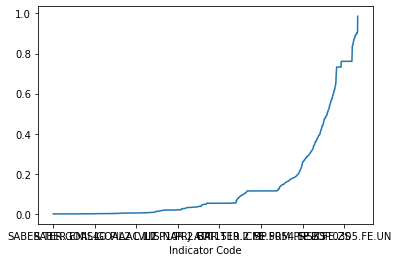

In [47]:
DataCleanIndGroupby=Data_Clean_IndicatorCode.groupby(["Indicator Code"])
# La multiplication finale permet de prendre en compte toute les années, et non uniquement une colonne d'année
(DataCleanIndGroupby.count().sum(axis=1) /(DataCleanIndGroupby.size() * (Data_Clean_IndicatorCode.shape[1]-1))) .sort_values().plot()

In [48]:
# La multiplication finale permet de prendre en compte toute les années, et non uniquement une colonne d'année
Indicator_True=(DataCleanIndGroupby.count().sum(axis=1)/(DataCleanIndGroupby.size()*(Data_Clean_IndicatorCode.shape[1]-1)))>=0.2

**Récuperer uniquement les indicateurs résultants du filtre**

In [49]:
Indicator_True=Indicator_True[Indicator_True==True].index

**Test sur resultat du filtre**

In [50]:
Data_Clean_IndicatorCode=Data_Clean_IndicatorCode[Data_Clean_IndicatorCode['Indicator Code'].isin(Indicator_True)]

In [51]:
Data_Clean_IndicatorCode

Indicator Code       1990       1991       1992       1993  \
0              UIS.NERA.2        NaN        NaN        NaN        NaN   
1            UIS.NERA.2.F        NaN        NaN        NaN        NaN   
2          UIS.NERA.2.GPI        NaN        NaN        NaN        NaN   
3            UIS.NERA.2.M        NaN        NaN        NaN        NaN   
4             SE.PRM.TENR  71.995819  72.602837  70.032722  70.464821   
...                   ...        ...        ...        ...        ...   
886609      UIS.UAPP.23.F        NaN        NaN        NaN        NaN   
886610      UIS.UAPP.23.M        NaN        NaN        NaN        NaN   
886611  SL.UEM.TOTL.FE.ZS        NaN   4.500000   4.500000   4.600000   
886612  SL.UEM.TOTL.MA.ZS        NaN   6.900000   7.100000   7.200000   
886613     SL.UEM.TOTL.ZS        NaN   5.800000   5.900000   6.000000   

             1994      1995       1996       1997       1998       1999  \
0             NaN       NaN        NaN        NaN        NaN        NaN   
1             NaN       NaN        NaN        NaN        NaN        NaN   
2             NaN       NaN        NaN        NaN        NaN        NaN   
3             NaN       NaN        NaN        NaN        NaN        NaN   
4       72.645683  71.81176  73.903511  74.425201  75.110817  76.254318   
...           ...       ...        ...        ...        ...        ...   
886609        NaN       NaN        NaN        NaN        NaN   0.976710   
886610        NaN       NaN        NaN        NaN        NaN   0.650040   
886611   3.800000   4.20000   4.600000   4.900000   4.800000   4.500000   
886612   6.100000   6.70000   7.300000   8.700000   8.200000   7.300000   
886613   5.000000   5.50000   6.000000   6.900000   6.600000   6.000000   

             2000       2001       2002       2003       2004       2005  \
0             NaN        NaN        NaN        NaN        NaN        NaN   
1             NaN        NaN        NaN        NaN        NaN        NaN   
2             NaN        NaN        NaN        NaN        NaN        NaN   
3             NaN        NaN        NaN        NaN        NaN        NaN   
4       77.245682  78.800522  80.051399  80.805389  81.607063  82.489487   
...           ...        ...        ...        ...        ...        ...   
886609   1.005390   1.026590   0.947850   0.982680        NaN        NaN   
886610   0.735380   0.745580   0.679710   0.686910        NaN        NaN   
886611   3.700000   4.500000   4.300000   4.000000   4.100000   4.300000   
886612   5.700000   7.500000   6.100000   4.900000   4.300000   5.300000   
886613   4.700000   6.100000   5.200000   4.500000   4.200000   4.800000   

             2006       2007       2008       2009       2010      2011  \
0             NaN        NaN        NaN        NaN        NaN       NaN   
1             NaN        NaN        NaN        NaN        NaN       NaN   
2             NaN        NaN        NaN        NaN        NaN       NaN   
3             NaN        NaN        NaN        NaN        NaN       NaN   
4       82.685509  83.280342  84.011871  84.195961  85.211998  85.24514   
...           ...        ...        ...        ...        ...       ...   
886609        NaN        NaN        NaN        NaN        NaN       NaN   
886610        NaN        NaN        NaN        NaN        NaN       NaN   
886611   4.500000   4.800000   5.300000   6.000000   4.600000   6.00000   
886612   6.700000   6.100000   5.500000   4.900000   7.700000   4.80000   
886613   5.600000   5.500000   5.400000   5.500000   6.200000   5.40000   

             2012      2013       2014  2015  
0             NaN       NaN        NaN   NaN  
1             NaN       NaN        NaN   NaN  
2             NaN       NaN        NaN   NaN  
3             NaN       NaN        NaN   NaN  
4       86.101669  85.51194  85.320152   NaN  
...           ...       ...        ...   ...  
886609   0.641460   0.72334        NaN   NaN  
886610   0.378340   0.44331        NaN   Na

### Merge Filter Country & Filter Indicator

**Prends en compte dans le dataset principal, les 2 filtres**

In [52]:
Data=Data[Data['Indicator Code'].isin(Indicator_True)]
Data=Data[Data['Country Name'].isin(Country_True)]

In [53]:
Data.head(200)

Country Name Country Code  \
95290      Albania          ALB   
95291      Albania          ALB   
95292      Albania          ALB   
95293      Albania          ALB   
95294      Albania          ALB   
95295      Albania          ALB   
95296      Albania          ALB   
95297      Albania          ALB   
95302      Albania          ALB   
95303      Albania          ALB   
95304      Albania          ALB   
95305      Albania          ALB   
95807      Albania          ALB   
95808      Albania          ALB   
95809      Albania          ALB   
95810      Albania          ALB   
95811      Albania          ALB   
95812      Albania          ALB   
95959      Albania          ALB   
95960      Albania          ALB   
95961      Albania          ALB   
95962      Albania          ALB   
95963      Albania          ALB   
95964      Albania          ALB   
95965      Albania          ALB   
95966      Albania          ALB   
95967      Albania          ALB   
95968      Albania          ALB   
95969      Albania          ALB   
95970      Albania          ALB   
95974      Albania          ALB   
95975      Albania          ALB   
95976      Albania          ALB   
95980      Albania          ALB   
95981      Albania          ALB   
95982      Albania          ALB   
95986      Albania          ALB   
95992      Albania          ALB   
95993      Albania          ALB   
95994      Albania          ALB   
95995      Albania          ALB   
95996      Albania          ALB   
95997      Albania          ALB   
95998      Albania          ALB   
95999      Albania          ALB   
96411      Albania          ALB   
96412      Albania          ALB   
96413      Albania          ALB   
96415      Albania          ALB   
96423      Albania          ALB   
96424      Albania          ALB   
96425      Albania          ALB   
96426      Albania          ALB   
96427      Albania          ALB   
96428      Albania          ALB   
96429      Albania          ALB   
96430      Albania          ALB   
96431      Albania          ALB   
96432      Albania          ALB   
96433      Albania          ALB   
96434      Albania          ALB   
96437      Albania          ALB   
96438      Albania          ALB   
96441      Albania          ALB   
96442      Albania          ALB   
96445      Albania          ALB   
96446      Albania          ALB   
96449      Albania          ALB   
96450      Albania          ALB   
96451      Albania          ALB   
96452      Albania          ALB   
96453      Albania          ALB   
96454      Albania          ALB   
96457      Albania          ALB   
96458      Albania          ALB   
96461      Albania          ALB   
96462      Albania          ALB   
96467      Albania          ALB   
96468      Albania          ALB   
96469      Albania          ALB   
96471      Albania          ALB   
96472      Albania          ALB   
96473      Albania          ALB   
96474      Albania          ALB   
96477      Albania          ALB   
96478      Albania          ALB   
96479      Albania          ALB   
96480      Albania          ALB   
96481      Albania          ALB   
96482      Albania          ALB   
96483      Albania          ALB   
96485      Albania          ALB   
96487      Albania          ALB   
96488      Albania          ALB   
96489      Albania          ALB   
96490      Albania          ALB   
96491      Albania          ALB   
96492      Albania          ALB   
96493      Albania          ALB   
96494      Albania          ALB   
96495      Albania          ALB   
96496      Albania          ALB   
96497      Albania          ALB   
96502      Albania          ALB   
96503      Albania          ALB   
96504      Albania          ALB   
96505      Albania          ALB   
96506      Albania          ALB   
96508      Albania          ALB   
96509      Albania          ALB   
96510      Albania          ALB   
96511      Albania          ALB   
96512      Albania          ALB   
96513      Alban

In [54]:
#(Data.isna()==True).sum()/Data.shape[0]

In [55]:
Data.shape

(97955, 30)

In [56]:
#Data.groupby(["Indicator Code"]).size().sort_values

## Exploratory Data Analysis

### Analysis by Indicator Code

Le choix ici est de partir sur une analyse à travers les codes indicateurs, de comprendre la signification de chaque code, ainsi de la segmentation de code. A partir de cela, definir des indicateurs d'ensembles.
Finalement apres segmentation des codes, je n'ai pas pu comprendre à la signification de chacun de ces codes. Je me suis donc rabbatu sur une autre possiblité à travers le dataset EdStatsSeries.

In [57]:
#Data['Indicator Name'].str.contains("%",regex=False)#.sum()#/Data.shape[0]

In [58]:
#IndicatorCodeTry=Data["Indicator Code"].str.split(".",expand=True)
#for i in IndicatorCodeTry.columns:
#    print (IndicatorCodeTry[i].unique())


In [59]:
#IndicatorCode=Data["Indicator Code"].str.split(".",expand=True)

In [60]:
#IndicatorCode

In [61]:
#IndicatorCode.groupby([0,1]).count()

In [62]:
#for i in IndicatorCode.columns:
#    print (IndicatorCode[i].unique())


In [63]:
#IndicatorCode[0].unique()

In [64]:
#serie_filter_by_data=
#Series[Series["Series Code"].isin(Data['Indicator Code'])]

### Analysis by Topic from EdStatsSeries

Cette deuxieme analyse prend un autre chemin, elle passe par le feature "Topic" afin de determiner la thématique de l'indicateur à travers une extraction depuis EdStatsSeries. Et une merge avec le dataset d'indicateur (avec les 2 filters Country & Indicator). A partir de ce merge, on a pu distinguer les différentes indicateurs extracts avec leurs thématiques.
J'ai selectionné et éliminé les thématiques qui ont peu d'intéret par rapport au sujet d'étude. Pour chaque thématique due à la quantité d'indicateurs (315 indicateurs au total), j'ai donc decidé de selectionner un certain nombre d'indicateurs pour chaque thématique.

###### 6 Thématiques : 

- Primary :
    - SE.PRM.TENR
    - UIS.NIRA.1
    - SE.PRM.DROP.ZS
    - UIS.DR.1.G1
    - UIS.DR.1.G2
    - UIS.DR.1.G3
    - SE.PRM.ENRR   #Taux brut
    - SE.PRM.NENR
    - SE.PRM.CMPT.ZS
    - UIS.ROFST.1

- Background : Durée de l'école =>non prise

- Secondary :
        
    - SE.SEC.ENRR.LO
    - SE.SEC.ENRR.UP
    - SE.SEC.CMPT.LO.ZS
    
    - Drop:
        - UIS.GER.12
        - SE.SEC.ENRR
        - UIS.NERA.2
        - SE.SEC.NENR
        - UIS.GTVP.2.GPV
        - UIS.GTVP.23.GPV #General
        - UIS.GTVP.3.GPV
        - UIS.NERT.2

- Tertiary :
    - SE.TER.ENRR
    - UIS.TEP.5.B
    - UIS.TEP.8

- Teachers : 
    - SE.PRM.ENRL.TC.ZS
    - SE.SEC.ENRL.TC.ZS
    - UIS.PTRHC.56
- Infrastructure: Communications : 
    - IT.NET.USER.P2
    - IT.CMP.PCMP.P2	

En realisant des graphiques sur les indicateurs, je me rends compte que cela est illisible (+200pays) et idealement sur une seule date, j'ai donc choisis de prendre 2010 (car date plus proche) /2005 (date plus éloigné mais plus de données) 

Ajout d'un systeme d'évaluation : 50% points d'accessibilité / 50% points sur le besoin 

Accessiblité => pc personnel+acces internet/2 => taux accessibilité


Questionnement => Quand l'ecole est obligatoire, elle est forcement gratuit (pendant les X ans obligatoire) => Abandonnée

**Au final, une grande partie des indicateurs et thématiques ont été abandonnée au profit de quelques indicateurs selectionné par leur disponibilité en données et l'utilité au besoin.**

- Secondary :   
    - SE.SEC.ENRR.LO
    - SE.SEC.ENRR.UP
    
- Tertiary :
    - SE.TER.ENRR
    
- Teachers : 
    - SE.SEC.ENRL.TC.ZS
    - UIS.PTRHC.56   

- Infrastructure: Communications : 
    - IT.NET.USER.P2
    - IT.CMP.PCMP.P2	

#### Extract topic from series
Nous avons extraire le topic via le Dataset Series (EdStatsSeries) qui contient l'information sur les thématiques de chaque indicateur

In [65]:
series_extract=Series[["Series Code","Topic"]]
series_extract=series_extract.rename(columns={"Series Code": "Indicator Code"})
#series_extract.dtypes

In [66]:
#Data.dtypes

**Merge les 2 datasets à travers un jointure left afin de garder les données de Data**

In [67]:
data_merge_series=pd.merge(Data, series_extract, how='left', on='Indicator Code')
data_merge_series

Country Name Country Code  \
0          Albania          ALB   
1          Albania          ALB   
2          Albania          ALB   
3          Albania          ALB   
4          Albania          ALB   
...            ...          ...   
97950       Zambia          ZMB   
97951       Zambia          ZMB   
97952       Zambia          ZMB   
97953       Zambia          ZMB   
97954       Zambia          ZMB   

                                                                Indicator Name  \
0                 Adjusted net enrolment rate, lower secondary, both sexes (%)   
1                     Adjusted net enrolment rate, lower secondary, female (%)   
2      Adjusted net enrolment rate, lower secondary, gender parity index (GPI)   
3                       Adjusted net enrolment rate, lower secondary, male (%)   
4                         Adjusted net enrolment rate, primary, both sexes (%)   
...                                                                        ...   
97950             Under-age enrolment ratio in secondary education, female (%)   
97951               Under-age enrolment ratio in secondary education, male (%)   
97952                           Unemployment, female (% of female labor force)   
97953                               Unemployment, male (% of male labor force)   
97954                             Unemployment, total (% of total labor force)   

          Indicator Code  1990  1991       1992       1993       1994  \
0             UIS.NERA.2   NaN   NaN        NaN        NaN        NaN   
1           UIS.NERA.2.F   NaN   NaN        NaN        NaN        NaN   
2         UIS.NERA.2.GPI   NaN   NaN        NaN        NaN        NaN   
3           UIS.NERA.2.M   NaN   NaN        NaN        NaN        NaN   
4            SE.PRM.TENR   NaN   NaN        NaN        NaN        NaN   
...                  ...   ...   ...        ...        ...        ...   
97950      UIS.UAPP.23.F   NaN   NaN        NaN        NaN        NaN   
97951      UIS.UAPP.23.M   NaN   NaN        NaN        NaN        NaN   
97952  SL.UEM.TOTL.FE.ZS   NaN  18.1  18.500000  18.900000  17.799999   
97953  SL.UEM.TOTL.MA.ZS   NaN  19.6  20.100000  20.500000  19.299999   
97954     SL.UEM.TOTL.ZS   NaN  18.9  19.299999  19.700001  18.600000   

            1995  1996  1997  1998       1999       2000       2001  2002  \
0            NaN   NaN   NaN   NaN        NaN  84.558281  85.306610   NaN   
1            NaN   NaN   NaN   NaN        NaN  83.848213  84.769829   NaN   
2            NaN   NaN   NaN   NaN        NaN   0.983600   0.987710   NaN   
3            NaN   NaN   NaN   NaN        NaN  85.246353  85.824432   NaN   
4            NaN   NaN   NaN   NaN  97.314247  95.889877  94.327347   NaN   
...          ...   ...   ...   ...        ...        ...        ...   ...   
97950        NaN   NaN   NaN   NaN        NaN        NaN        NaN   NaN   
97951        NaN   NaN   NaN   NaN        NaN        NaN        NaN   NaN   
97952  16.700001  14.3  12.9  11.5  11.900000  10.900000  13.100000  11.9   
97953  18.200001  15.6  14.1  12.5  13.000000  14.800000  14.300000  13.5   
97954  17.400000  15.0  13.5  12.0  12.500000  12.900000  13.700000  12.7   

            2003      2004  2005  2006  2007       2008       2009       2010  \
0            NaN       NaN   NaN   NaN   NaN        NaN        NaN        NaN   
1            NaN       NaN   NaN   NaN   NaN        NaN        NaN        NaN   
2            NaN       NaN   NaN   NaN   NaN        NaN        NaN        NaN   
3            NaN       NaN   NaN   NaN   NaN        NaN        NaN        NaN   
4      91.710312  91.11129   NaN   NaN   NaN  90.267288  89.393333  91.033867   
...          ...       ...   ...   ...   ...        ...        ...        ...   
97950        NaN       NaN   NaN   NaN   NaN        NaN        NaN        NaN   
97951        NaN       NaN   NaN   NaN   NaN        NaN        NaN        NaN   
97952  15.800000  16.00000  16.6  13.7  11.7   7.600000   8.400000  1

**Aperçu des données disponibles**

In [68]:
#data_merge_series["Topic"].unique()

array(['Secondary', 'Primary', 'Background', nan,
       'Early Childhood Education', 'Tertiary', 'Expenditures',
       'Economic Policy & Debt: National accounts: US$ at constant 2010 prices: Aggregate indicators',
       'Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators',
       'Economic Policy & Debt: Purchasing power parity',
       'Economic Policy & Debt: National accounts: Atlas GNI & GNI per capita',
       'Pre-Primary', 'Infrastructure: Communications',
       'Social Protection & Labor: Labor force structure',
       'Health: Mortality', 'Teachers', 'Health: Population: Dynamics',
       'Population', 'Health: Population: Structure',
       'Health: Risk factors', 'Social Protection & Labor: Unemployment'],
      dtype=object)

### Extract from Region, Income Group from Country
**Extraction des regions et des revenues par pays**

In [69]:
country_extract=Country[["Country Code","Region","Income Group"]]

In [70]:
#country_extract.dtypes

In [71]:
data_merge_series=pd.merge(data_merge_series, country_extract, how='left', on='Country Code')

In [72]:
data_merge_series

Country Name Country Code  \
0          Albania          ALB   
1          Albania          ALB   
2          Albania          ALB   
3          Albania          ALB   
4          Albania          ALB   
...            ...          ...   
97950       Zambia          ZMB   
97951       Zambia          ZMB   
97952       Zambia          ZMB   
97953       Zambia          ZMB   
97954       Zambia          ZMB   

                                                                Indicator Name  \
0                 Adjusted net enrolment rate, lower secondary, both sexes (%)   
1                     Adjusted net enrolment rate, lower secondary, female (%)   
2      Adjusted net enrolment rate, lower secondary, gender parity index (GPI)   
3                       Adjusted net enrolment rate, lower secondary, male (%)   
4                         Adjusted net enrolment rate, primary, both sexes (%)   
...                                                                        ...   
97950             Under-age enrolment ratio in secondary education, female (%)   
97951               Under-age enrolment ratio in secondary education, male (%)   
97952                           Unemployment, female (% of female labor force)   
97953                               Unemployment, male (% of male labor force)   
97954                             Unemployment, total (% of total labor force)   

          Indicator Code  1990  1991       1992       1993       1994  \
0             UIS.NERA.2   NaN   NaN        NaN        NaN        NaN   
1           UIS.NERA.2.F   NaN   NaN        NaN        NaN        NaN   
2         UIS.NERA.2.GPI   NaN   NaN        NaN        NaN        NaN   
3           UIS.NERA.2.M   NaN   NaN        NaN        NaN        NaN   
4            SE.PRM.TENR   NaN   NaN        NaN        NaN        NaN   
...                  ...   ...   ...        ...        ...        ...   
97950      UIS.UAPP.23.F   NaN   NaN        NaN        NaN        NaN   
97951      UIS.UAPP.23.M   NaN   NaN        NaN        NaN        NaN   
97952  SL.UEM.TOTL.FE.ZS   NaN  18.1  18.500000  18.900000  17.799999   
97953  SL.UEM.TOTL.MA.ZS   NaN  19.6  20.100000  20.500000  19.299999   
97954     SL.UEM.TOTL.ZS   NaN  18.9  19.299999  19.700001  18.600000   

            1995  1996  1997  1998       1999       2000       2001  2002  \
0            NaN   NaN   NaN   NaN        NaN  84.558281  85.306610   NaN   
1            NaN   NaN   NaN   NaN        NaN  83.848213  84.769829   NaN   
2            NaN   NaN   NaN   NaN        NaN   0.983600   0.987710   NaN   
3            NaN   NaN   NaN   NaN        NaN  85.246353  85.824432   NaN   
4            NaN   NaN   NaN   NaN  97.314247  95.889877  94.327347   NaN   
...          ...   ...   ...   ...        ...        ...        ...   ...   
97950        NaN   NaN   NaN   NaN        NaN        NaN        NaN   NaN   
97951        NaN   NaN   NaN   NaN        NaN        NaN        NaN   NaN   
97952  16.700001  14.3  12.9  11.5  11.900000  10.900000  13.100000  11.9   
97953  18.200001  15.6  14.1  12.5  13.000000  14.800000  14.300000  13.5   
97954  17.400000  15.0  13.5  12.0  12.500000  12.900000  13.700000  12.7   

            2003      2004  2005  2006  2007       2008       2009       2010  \
0            NaN       NaN   NaN   NaN   NaN        NaN        NaN        NaN   
1            NaN       NaN   NaN   NaN   NaN        NaN        NaN        NaN   
2            NaN       NaN   NaN   NaN   NaN        NaN        NaN        NaN   
3            NaN       NaN   NaN   NaN   NaN        NaN        NaN        NaN   
4      91.710312  91.11129   NaN   NaN   NaN  90.267288  89.393333  91.033867   
...          ...       ...   ...   ...   ...        ...        ...        ...   
97950        NaN       NaN   NaN   NaN   NaN        NaN        NaN        NaN   
97951        NaN       NaN   NaN   NaN   NaN        NaN        NaN        NaN   
97952  15.800000  16.00000  16.6  13.7  11.7   7.600000   8.400000  1

In [73]:
data_merge_series=data_merge_series[data_merge_series["Topic"].isin([#'Primary',  #'Background',
                                                                     'Secondary','Tertiary','Teachers','Infrastructure: Communications'])]

**Quelques Opérations de test**

In [74]:
#data_merge_series[data_merge_series["Topic"]=='Infrastructure: Communications']

In [75]:
#data_merge_series[(data_merge_series["Topic"]=='Tertiary') & (data_merge_series["Country Name"]=='China')] # &
                  #(data_merge_series["Indicator Name"].str.contains("%",regex=False))]

In [76]:
#data_merge_series[(data_merge_series["Topic"]=='Secondary')] # & (data_merge_series["Country Name"]=='France')]

In [77]:
#data_merge_series[(data_merge_series["Topic"]=='Primary')].isna().sum()/data_merge_series[(data_merge_series["Topic"]=='Primary')].shape[0]

In [78]:
#data_merge_series[(data_merge_series["Topic"]=='Secondary')].isna().sum()/data_merge_series[(data_merge_series["Topic"]=='Secondary')].shape[0]

In [79]:
#data_merge_series['Indicator Code'].unique()

In [80]:
#data_merge_series.groupby('Indicator Code').count()

In [81]:
#data_merge_series.set_index(["Country Name"], inplace=True)

In [82]:
#Pourcentage de NA avec selection de thématiques & filtrage par indicateur (+40% données) & filtrage par pays (+20% données)

data_merge_series.isna().sum()/data_merge_series.shape[0]

Country Name      0.000000
Country Code      0.000000
Indicator Name    0.000000
Indicator Code    0.000000
1990              0.737374
1991              0.730104
1992              0.733473
1993              0.712551
1994              0.689234
1995              0.699223
1996              0.701912
1997              0.746033
1998              0.697863
1999              0.377996
2000              0.366914
2001              0.337569
2002              0.319513
2003              0.341470
2004              0.295251
2005              0.296729
2006              0.299802
2007              0.297408
2008              0.291793
2009              0.300068
2010              0.298324
2011              0.290582
2012              0.302432
2013              0.318804
2014              0.455776
2015              0.816336
Topic             0.000000
Region            0.000000
Income Group      0.000000
dtype: float64

### Topic Accessibility (Communication)

A travers les différentes indicateurs, plusieurs indicateurs m'a paru pertinant,en autre :
- indicateur sur la disponibilité de Internet sur 100 utilisateurs
- indicateur sur la disponibilité d'un PC personnel sur 100 utilisateurs  
  
**Indicateur d'Internet**

In [83]:
# Disponibilité de données % Internet/100 users pour chaque région du monde (% NA)

internet_ind=data_merge_series[(data_merge_series["Indicator Code"]=='IT.NET.USER.P2')]
internet_ind.groupby("Region").count().div(internet_ind.groupby("Region").size(), axis=0)

Country Name  Country Code  Indicator Name  \
Region                                                                   
East Asia & Pacific                  1.0           1.0             1.0   
Europe & Central Asia                1.0           1.0             1.0   
Latin America & Caribbean            1.0           1.0             1.0   
Middle East & North Africa           1.0           1.0             1.0   
North America                        1.0           1.0             1.0   
South Asia                           1.0           1.0             1.0   
Sub-Saharan Africa                   1.0           1.0             1.0   

                            Indicator Code  1990      1991      1992  \
Region                                                                 
East Asia & Pacific                    1.0   1.0  0.312500  0.437500   
Europe & Central Asia                  1.0   1.0  0.441860  0.534884   
Latin America & Caribbean              1.0   1.0  0.080000  0.280000   
Middle East & North Africa             1.0   1.0  0.133333  0.133333   
North America                          1.0   1.0  1.000000  1.000000   
South Asia                             1.0   1.0  0.200000  0.400000   
Sub-Saharan Africa                     1.0   1.0  0.125000  0.093750   

                                1993      1994      1995      1996      1997  \
Region                                                                         
East Asia & Pacific         0.500000  0.687500  0.812500  0.875000  0.937500   
Europe & Central Asia       0.720930  0.837209  0.906977  0.953488  0.953488   
Latin America & Caribbean   0.280000  0.520000  0.880000  1.000000  1.000000   
Middle East & North Africa  0.266667  0.466667  0.933333  0.933333  0.933333   
North America               1.000000  1.000000  1.000000  1.000000  1.000000   
South Asia                  0.400000  0.600000  0.800000  0.800000  1.000000   
Sub-Saharan Africa          0.125000  0.187500  0.500000  0.843750  1.000000   

                                1998      1999  2000  2001    2002      2003  \
Region                                                                         
East Asia & Pacific         1.000000  1.000000   1.0  1.00  0.9375  0.875000   
Europe & Central Asia       0.976744  1.000000   1.0  1.00  1.0000  0.953488   
Latin America & Caribbean   1.000000  1.000000   1.0  0.96  0.9600  0.920000   
Middle East & North Africa  0.933333  0.933333   1.0  1.00  1.0000  1.000000   
North America               1.000000  1.000000   1.0  1.00  1.0000  1.000000   
South Asia                  1.000000  1.000000   0.8  1.00  1.0000  1.000000   
Sub-Saharan Africa          1.000000  1.000000   1.0  1.00  1.0000  0.968750   

                                2004      2005    2006  2007  2008  2009  \
Region                                                                     
East Asia & Pacific         0.875000  0.937500  0.9375   1.0   1.0   1.0   
Europe & Central Asia       0.953488  0.976744  1.0000   1.0   1.0   1.0   
Latin America & Caribbean   0.960000  0.960000  0.9600   1.0   1.0   1.0   
Middle East & North Africa  1.000000  1.000000  1.0000   1.0   1.0   1.0   
North America               1.000000  1.000000  1.0000   1.0   1.0   1.0   
South Asia                  1.000000  1.000000  1.0000   1.0   1.0   1.0   
Sub-Saharan Africa          0.968750  0.968750  0.9375   1.0   1.0   1.0   

                            2010  2011  2012  2013  2014  2015  Topic  \
Region                                                                  
East Asia & Pacific          1.0   1.0   1.0   1.0   1.0   1.0    1.0   
Europe & Central Asia        1.0   1.0   1.0   1.0   1.0   1.0    1.0   
Latin America & Caribbean    1.0   1.0   1.0   1.0   1.0   1.0    1.0   
Middle East & North Africa   1.0   1.0   1.0   1.0   1.0   1.0    1.0   
North America                1.0   1.0   1.0   1.0   1.0   1.0    1.0   
South Asia                   1.0   1.0   1.0   1.0   1.0   1.0    1.0   
S

In [84]:
# Moyenne entre nb Internet/100 users pour chaque pays

df1=internet_ind.drop(["Country Code","Indicator Name","Indicator Code"], axis=1)
df1.set_index("Country Name", inplace=True)
df1

1990      1991      1992      1993      1994  \
Country Name                                                             
Albania               0.000000       NaN       NaN       NaN       NaN   
Algeria               0.000000       NaN       NaN       NaN  0.000361   
Argentina             0.000000       NaN  0.002993  0.029527  0.043706   
Armenia               0.000000       NaN       NaN       NaN  0.009117   
Australia             0.585095  1.097204  1.768765  1.974611  2.232101   
Austria               0.130369  0.259082  0.642818  0.765343  1.393423   
Azerbaijan            0.000000       NaN       NaN       NaN  0.001431   
Bahrain               0.000000       NaN       NaN       NaN       NaN   
Bangladesh            0.000000       NaN       NaN       NaN       NaN   
Barbados              0.000000       NaN       NaN       NaN       NaN   
Belarus               0.000000       NaN       NaN       NaN  0.000486   
Belgium               0.001007  0.020073  0.100041  0.199446  0.695995   
Belize                0.000000       NaN       NaN       NaN       NaN   
Benin                 0.000000       NaN       NaN       NaN       NaN   
Bolivia               0.000000       NaN       NaN       NaN       NaN   
Botswana              0.000000  0.000000       NaN       NaN       NaN   
Brazil                0.000000  0.003288  0.012946  0.025498  0.037673   
Brunei Darussalam     0.000000       NaN       NaN       NaN       NaN   
Bulgaria              0.000000       NaN       NaN  0.002339  0.019527   
Burkina Faso          0.000000       NaN       NaN       NaN       NaN   
Burundi               0.000000  0.000000  0.000000  0.000000  0.000000   
Cabo Verde            0.000000       NaN       NaN       NaN       NaN   
Cambodia              0.000000       NaN       NaN       NaN       NaN   
Cameroon              0.000000       NaN       NaN       NaN       NaN   
Chad                  0.000000       NaN       NaN       NaN       NaN   
Chile                 0.000000       NaN  0.036549  0.071783  0.141085   
China                 0.000000       NaN       NaN  0.000169  0.001168   
Colombia              0.000000       NaN       NaN       NaN  0.107174   
Congo, Rep.           0.000000       NaN       NaN       NaN       NaN   
Costa Rica            0.000000       NaN  0.001113  0.081510  0.279912   
Cote d'Ivoire         0.000000       NaN       NaN       NaN       NaN   
Croatia               0.000000       NaN       NaN  0.097213  0.268319   
Cuba                  0.000000       NaN       NaN       NaN       NaN   
Cyprus                0.000000       NaN  0.050060  0.056367  0.111035   
Czech Republic        0.000000       NaN       NaN  0.581320  1.259218   
Denmark               0.097277  0.194057  0.386914  0.578330  1.344308   
Dominican Republic    0.000000       NaN       NaN       NaN       NaN   
Ecuador               0.000000       NaN  0.005118  0.016401  0.034834   
Egypt, Arab Rep.      0.000000       NaN       NaN  0.000976  0.006383   
El Salvador           0.000000       NaN       NaN       NaN       NaN   
Eritrea               0.000000       NaN       NaN  0.000000  0.000000   
Estonia               0.000000       NaN  0.065485  0.300711  1.159751   
Ethiopia              0.000000       NaN       NaN       NaN       NaN   
Finland               0.401088  1.397439  1.886880  2.568461  4.915099   
France                0.052778  0.140114  0.279049  0.590619  0.899867   
Gambia, The           0.000000       NaN       NaN       NaN       NaN   
Georgia               0.000000       NaN       NaN       NaN       NaN   
Germany               0.125892  0.250274  0.435285  0.463635  0.922541   
Ghana                 0.000000       NaN       NaN       NaN       NaN   
Greece                0.000000  0.048789  0.048292  0.191062  0.378174   
Guatemala             0.000000       NaN       NaN       NaN       NaN   
Guinea                0.000000       NaN       NaN       NaN  0.000138   
Guyana                0.000000

**Mini Synthese sur l'indicateur Internet/100**  
Suite au différent check sur le dataset, les données sur l'indicateur d'internet est très limité, mais la donnée restait intéressant.Le choix de la fonction interpolation a été faite afin d'obtenir plus de données.

In [85]:
data_interpolate=data_merge_series[(data_merge_series["Indicator Code"]=='IT.CMP.PCMP.P2')][["Country Name",#"Country Code","Indicator Name","Indicator Code",
           "1990", "1991", "1992", "1993", "1994","1995", "1996", "1997", "1998", "1999",
     "2000","2001","2002","2003","2004","2005","2006","2007","2008","2009",
     "2010","2011","2012","2013","2014","2015"]]
data_interpolate.set_index("Country Name", inplace=True)
data_interpolate


1990       1991       1992       1993       1994  \
Country Name                                                                  
Albania                     NaN        NaN        NaN        NaN        NaN   
Algeria                0.095275   0.145016   0.174323   0.213087   0.250411   
Argentina              0.720309   0.876790   0.984463   1.354457   3.436112   
Armenia                     NaN        NaN        NaN        NaN        NaN   
Australia             14.950106  16.004245  18.360420  20.678598  23.923049   
Austria                6.518904   7.765546   8.977585  10.162136  11.337547   
Azerbaijan                  NaN        NaN        NaN        NaN        NaN   
Bahrain                     NaN        NaN        NaN        NaN        NaN   
Bangladesh                  NaN        NaN        NaN        NaN        NaN   
Barbados                    NaN        NaN        NaN        NaN        NaN   
Belarus                     NaN        NaN        NaN        NaN        NaN   
Belgium                8.779102   9.938995  11.940369  13.873532  15.795251   
Belize                      NaN        NaN        NaN        NaN        NaN   
Benin                       NaN        NaN        NaN        NaN        NaN   
Bolivia                     NaN   0.215618   0.238654   0.274245   0.294757   
Botswana                    NaN        NaN        NaN        NaN   0.647306   
Brazil                 0.300705   0.427200   0.614497   0.827967   1.129002   
Brunei Darussalam           NaN        NaN   1.103205   1.787936   2.783867   
Bulgaria                    NaN        NaN   1.040038   1.169257   1.419844   
Burkina Faso           0.011565        NaN        NaN   0.018843   0.022411   
Burundi                     NaN        NaN        NaN        NaN        NaN   
Cabo Verde                  NaN        NaN        NaN        NaN        NaN   
Cambodia                    NaN        NaN        NaN        NaN        NaN   
Cameroon                    NaN        NaN        NaN        NaN        NaN   
Chad                        NaN        NaN        NaN        NaN        NaN   
Chile                  0.930836   1.307920   1.670742   2.120590   2.597727   
China                  0.042903   0.067624   0.091753   0.115406   0.163143   
Colombia                    NaN        NaN   0.924637   1.106055   1.392159   
Congo, Rep.                 NaN        NaN        NaN        NaN        NaN   
Costa Rica                  NaN        NaN        NaN        NaN        NaN   
Cote d'Ivoire               NaN        NaN        NaN        NaN        NaN   
Croatia                     NaN   1.458617   1.566536   1.679816   1.797592   
Cuba                        NaN        NaN        NaN        NaN        NaN   
Cyprus                 0.652221   1.276914   1.873454   2.442557   2.986266   
Czech Republic         1.162118   1.452081   2.418672   2.900766   4.350393   
Denmark               11.477858  13.386857  15.469986  17.916897  19.188993   
Dominican Republic          NaN        NaN        NaN        NaN        NaN   
Ecuador                     NaN   0.193038   0.377424   0.645975   0.993187   
Egypt, Arab Rep.            NaN        NaN        NaN        NaN   0.322089   
El Salvador                 NaN        NaN        NaN        NaN        NaN   
Eritrea                     NaN        NaN        NaN        NaN        NaN   
Estonia                     NaN        NaN        NaN        NaN        NaN   
Ethiopia                    NaN        NaN        NaN        NaN        NaN   
Finland               10.026661  11.378651  12.909894  14.225130  15.924509   
France                 7.036591   7.355774  10.812867  11.638008  13.496608   
Gambia, The                 NaN        NaN        NaN        NaN   0.028941   
Georgia                     NaN        NaN        NaN        NaN        NaN   
Germany                8.075822   9.256234  10.780989  12.404960  14.863971   
Ghana                  0.004977   0.009971   0.032317   0.062864   0.091803  

In [86]:
(data_interpolate.groupby("Country Name").count().sum(axis=1))/data_interpolate.shape[1]

Country Name
Albania                 0.500000
Algeria                 0.615385
Argentina               0.615385
Armenia                 0.346154
Australia               0.538462
Austria                 0.615385
Azerbaijan              0.307692
Bahrain                 0.538462
Bangladesh              0.384615
Barbados                0.423077
Belarus                 0.038462
Belgium                 0.615385
Belize                  0.500000
Benin                   0.500000
Bolivia                 0.576923
Botswana                0.538462
Brazil                  0.615385
Brunei Darussalam       0.538462
Bulgaria                0.576923
Burkina Faso            0.576923
Burundi                 0.269231
Cabo Verde              0.423077
Cambodia                0.500000
Cameroon                0.423077
Chad                    0.307692
Chile                   0.615385
China                   0.653846
Colombia                0.653846
Congo, Rep.             0.307692
Costa Rica              0.3461

**Fonction d'interpolation**  
Prend en entrée l'index des pays et remplie les NaN avec l'interpolation "InterpolatedUnivariateSpline" basé sur le Spline de degre 1. 
L'interpolation classique ne fonctionne pas correctement ici, puiqu'elle ne remplie les données manquantes en extrémité, ainsi je me suis rabbattue sur "InterpolatedUnivariateSpline" qui à partir de données d'origine et de leur position, definie le Spline. Ce même Spline va définir les données manquantes en leur donnants les positions souhaités.  
Les parties commentés avec ''' represente le mise en place d'une test sur les données prédites,elles sont mis en commentaires dans pour l'usage habituel, puisqu'on possede peu de données. A décommenter si on souhaite voir les resultats de la différence entre le predict/reel. 
  
x_base=index de base qui va servir pour definir le spline  
y_base=valeur de base qui va servir pour definir le spline   
x_inter=index total qu'on souhaite predire avec le spline   
y_pred= valeur prédicte avec le spline 

In [87]:
def MyfunctionInterpolate(dataIndex):

    for i in dataIndex:

        tmp=data_interpolate.loc[i][data_interpolate.loc[i].isna()==False]

        #Un Spline est defini sur 2 point ou plus
        if tmp.size>2 : 
            
            x_base = [int(numeric_string)-1990 for numeric_string in tmp.index]
            n=data_interpolate.shape[1]
            x_inter=np.linspace(0, n-1 , n)
            y_base=tmp.array

            ser_base = pd.Series(y_base, index =x_base) 
            print("Serie de base :\n", ser_base)


            '''
            #Serie qui me sert de test d'erreur sur 20% des données de la serie
            ser_sample = ser_base.sample(frac=0.2, random_state=1)
            print("Serie de Sample :\n", ser_sample )

            #Drop les données utilisées pour le test
            ser_base.drop(ser_sample.index, inplace=True, axis=0)
            print("Serie de base droped :\n", ser_base)
            '''


            #mise en place du Spline
            s = InterpolatedUnivariateSpline(ser_base.index, ser_base.values, k=1)
            #prédiction
            y_pred = s(x_inter)
            print(y_pred)
            ser_inter = pd.Series(y_pred, index=data_interpolate.columns)
            print("Serie de interpolé :\n", ser_inter)


            '''
            mean_Err_marge=0
            #Marge d'erreur
            for item in ser_sample.index:
                obj=str(item+1990)
                print("Pour emplacement ",item)
                print("ser_sample: ",ser_sample.loc[item])
                print("ser_inter: ",ser_inter.loc[obj])
                mean_Err_marge=mean_Err_marge + np.abs(ser_sample.loc[item]-ser_inter.loc[obj])

            mean_Err_marge=mean_Err_marge/ser_sample.size 
            print("\nMean Marge Error:",mean_Err_marge,"\n")
            '''

            #Ce if sert à tester un pays en particulier, ici Bahrain
            if(i=="Bahrain"):
                plt.scatter(x_base,y_base,c='b')
                plt.scatter(x_inter,y_pred, c='r')
                print(x_base)
                print(y_base)
                print(x_inter)
                print(y_pred)

                
                
            print(data_interpolate.loc[i])
            #ser_inter.index=ser_inter.index.astype(int)+1990
            #ser_inter.name=i
            print("ser_inter : ",ser_inter)
            data_interpolate.loc[i].update(ser_inter)

        else :

            data_interpolate.loc[i]=data_interpolate.loc[i].interpolate(limit_direction='both')

    ### Enlever les ''' pour avoir la verification avec train/test de 20% de l'interpolation

Serie de base :
 6     0.149654
7     0.300182
8     0.451066
9     0.602783
10    0.756442
11    0.912941
12    1.103078
13    1.296542
14    1.492446
15    1.689543
16    3.774092
17    4.105840
18    4.593538
dtype: float64
[-7.53512420e-01 -6.02984706e-01 -4.52456991e-01 -3.01929277e-01
 -1.51401563e-01 -8.73848689e-04  1.49653866e-01  3.00181580e-01
  4.51065959e-01  6.02783473e-01  7.56441554e-01  9.12940753e-01
  1.10307771e+00  1.29654240e+00  1.49244589e+00  1.68954329e+00
  3.77409168e+00  4.10583970e+00  4.59353838e+00  5.08123706e+00
  5.56893573e+00  6.05663441e+00  6.54433309e+00  7.03203176e+00
  7.51973044e+00  8.00742911e+00]
Serie de interpolé :
 1990   -0.753512
1991   -0.602985
1992   -0.452457
1993   -0.301929
1994   -0.151402
1995   -0.000874
1996    0.149654
1997    0.300182
1998    0.451066
1999    0.602783
2000    0.756442
2001    0.912941
2002    1.103078
2003    1.296542
2004    1.492446
2005    1.689543
2006    3.774092
2007    4.105840
2008    4.593538
2009

 0     11.477858
1     13.386857
2     15.469986
3     17.916897
4     19.188993
5     26.755434
6     30.450768
7     36.007469
8     37.745250
9     45.117786
10    50.578060
11    54.158191
12    57.738936
13    61.565865
14    65.628636
15    69.623744
16    72.818527
17    54.869173
dtype: float64
[ 11.47785785  13.38685748  15.46998591  17.91689681  19.18899258
  26.75543355  30.45076843  36.00746909  37.74524976  45.11778562
  50.5780604   54.15819122  57.73893582  61.56586479  65.62863639
  69.62374384  72.8185273   54.86917269  36.91981808  18.97046347
   1.02110886 -16.92824575 -34.87760036 -52.82695497 -70.77630958
 -88.72566419]
Serie de interpolé :
 1990    11.477858
1991    13.386857
1992    15.469986
1993    17.916897
1994    19.188993
1995    26.755434
1996    30.450768
1997    36.007469
1998    37.745250
1999    45.117786
2000    50.578060
2001    54.158191
2002    57.738936
2003    61.565865
2004    65.628636
2005    69.623744
2006    72.818527
2007    54.869173
2008 

 6     0.100269
7     0.156964
8     0.192274
9     0.226494
10    0.259823
11    0.292496
12    0.324602
13    0.355931
14    0.386025
15    1.726923
dtype: float64
[-2.39899259e-01 -1.83204569e-01 -1.26509879e-01 -6.98151892e-02
 -1.31204991e-02  4.35741910e-02  1.00268881e-01  1.56963571e-01
  1.92274488e-01  2.26494325e-01  2.59823124e-01  2.92495534e-01
  3.24602430e-01  3.55930849e-01  3.86025051e-01  1.72692304e+00
  3.06782103e+00  4.40871902e+00  5.74961701e+00  7.09051500e+00
  8.43141299e+00  9.77231098e+00  1.11132090e+01  1.24541070e+01
  1.37950050e+01  1.51359029e+01]
Serie de interpolé :
 1990    -0.239899
1991    -0.183205
1992    -0.126510
1993    -0.069815
1994    -0.013120
1995     0.043574
1996     0.100269
1997     0.156964
1998     0.192274
1999     0.226494
2000     0.259823
2001     0.292496
2002     0.324602
2003     0.355931
2004     0.386025
2005     1.726923
2006     3.067821
2007     4.408719
2008     5.749617
2009     7.090515
2010     8.431413
2011     9

 0      0.337499
1      0.437481
2      0.638448
3      0.786065
4      1.142753
5      1.749638
6      2.358884
7      2.971368
8      3.452582
9      3.734488
10     6.336752
11     7.525471
12     8.933430
13     8.972965
14    10.392752
15    12.088961
16    13.220608
dtype: float64
[ 0.33749862  0.43748069  0.63844798  0.78606487  1.14275265  1.74963825
  2.35888404  2.97136845  3.45258167  3.73448808  6.33675214  7.52547131
  8.93343002  8.97296517 10.39275237 12.08896091 13.22060812 14.35225533
 15.48390253 16.61554974 17.74719695 18.87884416 20.01049136 21.14213857
 22.27378578 23.40543298]
Serie de interpolé :
 1990     0.337499
1991     0.437481
1992     0.638448
1993     0.786065
1994     1.142753
1995     1.749638
1996     2.358884
1997     2.971368
1998     3.452582
1999     3.734488
2000     6.336752
2001     7.525471
2002     8.933430
2003     8.972965
2004    10.392752
2005    12.088961
2006    13.220608
2007    14.352255
2008    15.483903
2009    16.615550
2010    17.7

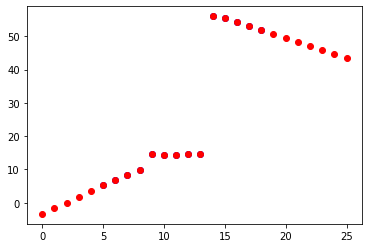

In [88]:
MyfunctionInterpolate(data_interpolate.index)

In [89]:
data_interpolate

1990       1991       1992       1993       1994  \
Country Name                                                                  
Albania               -0.753512  -0.602985  -0.452457  -0.301929  -0.151402   
Algeria                0.095275   0.145016   0.174323   0.213087   0.250411   
Argentina              0.720309   0.876790   0.984463   1.354457   3.436112   
Armenia               -1.078288  -0.883270  -0.688252  -0.493234  -0.298216   
Australia             14.950106  16.004245  18.360420  20.678598  23.923049   
Austria                6.518904   7.765546   8.977585  10.162136  11.337547   
Azerbaijan            -2.762795  -2.447768  -2.132741  -1.817714  -1.502687   
Bahrain               -3.368857  -1.657355   0.054147   1.765650   3.477152   
Bangladesh            -0.466850  -0.396727  -0.326604  -0.256481  -0.186358   
Barbados               3.882726   4.246150   4.609574   4.972998   5.336422   
Belarus                0.817567   0.817567   0.817567   0.817567   0.817567   
Belgium                8.779102   9.938995  11.940369  13.873532  15.795251   
Belize                -6.148763  -4.339194  -2.529625  -0.720056   1.089514   
Benin                 -0.023099  -0.008455   0.006189   0.020832   0.035476   
Bolivia                0.192583   0.215618   0.238654   0.274245   0.294757   
Botswana              -0.552659  -0.252667   0.047324   0.347315   0.647306   
Brazil                 0.300705   0.427200   0.614497   0.827967   1.129002   
Brunei Darussalam     -0.266258   0.418473   1.103205   1.787936   2.783867   
Bulgaria               0.781599   0.910818   1.040038   1.169257   1.419844   
Burkina Faso           0.011565   0.013991   0.016417   0.018843   0.022411   
Burundi                0.074398   0.072951   0.071505   0.070058   0.068611   
Cabo Verde            -5.343449  -4.528781  -3.714113  -2.899445  -2.084777   
Cambodia              -0.037010  -0.020322  -0.003635   0.013053   0.029741   
Cameroon              -0.011615   0.019424   0.050463   0.081502   0.112541   
Chad                  -0.067516  -0.046131  -0.024745  -0.003359   0.018026   
Chile                  0.930836   1.307920   1.670742   2.120590   2.597727   
China                  0.042903   0.067624   0.091753   0.115406   0.163143   
Colombia               0.561802   0.743219   0.924637   1.106055   1.392159   
Congo, Rep.            0.107495   0.132047   0.156600   0.181152   0.205705   
Costa Rica            -1.316879  -0.152425   1.012029   2.176483   3.340937   
Cote d'Ivoire         -1.037614  -0.841898  -0.646182  -0.450466  -0.254749   
Croatia                1.350699   1.458617   1.566536   1.679816   1.797592   
Cuba                  -0.074773   0.013659   0.102092   0.190525   0.278957   
Cyprus                 0.652221   1.276914   1.873454   2.442557   2.986266   
Czech Republic         1.162118   1.452081   2.418672   2.900766   4.350393   
Denmark               11.477858  13.386857  15.469986  17.916897  19.188993   
Dominican Republic     1.024270   1.106789   1.189307   1.271825   1.354344   
Ecuador                0.008653   0.193038   0.377424   0.645975   0.993187   
Egypt, Arab Rep.      -0.024388   0.062231   0.148850   0.235470   0.322089   
El Salvador           -1.257679  -0.930528  -0.603377  -0.276226   0.050925   
Eritrea                0.068137   0.076960   0.085784   0.094607   0.103431   
Estonia              -10.569041  -7.627612  -4.686182  -1.744753   1.196677   
Ethiopia              -0.055926  -0.041919  -0.027912  -0.013905   0.000102   
Finland               10.026661  11.378651  12.909894  14.225130  15.924509   
France                 7.036591   7.355774  10.812867  11.638008  13.496608   
Gambia, The           -0.099254  -0.067205  -0.035156  -0.003107   0.028941   
Georgia               -0.430756  -0.151572   0.127611   0.406795   0.685979   
Germany                8.075822   9.256234  10.780989  12.404960  14.863971   
Ghana                  0.004977   0.009971   0.032317   0.062864   0.091803  

**Ajout de Region**

In [90]:
country_extract_inter=Country[["Table Name","Region"]]
country_extract_inter=country_extract_inter.rename(columns={"Table Name": "Country Name"})
data_interpolate_merge=pd.merge(data_interpolate, country_extract_inter, how='left', on='Country Name')
data_interpolate_merge

Country Name       1990       1991       1992       1993  \
0                 Albania  -0.753512  -0.602985  -0.452457  -0.301929   
1                 Algeria   0.095275   0.145016   0.174323   0.213087   
2               Argentina   0.720309   0.876790   0.984463   1.354457   
3                 Armenia  -1.078288  -0.883270  -0.688252  -0.493234   
4               Australia  14.950106  16.004245  18.360420  20.678598   
5                 Austria   6.518904   7.765546   8.977585  10.162136   
6              Azerbaijan  -2.762795  -2.447768  -2.132741  -1.817714   
7                 Bahrain  -3.368857  -1.657355   0.054147   1.765650   
8              Bangladesh  -0.466850  -0.396727  -0.326604  -0.256481   
9                Barbados   3.882726   4.246150   4.609574   4.972998   
10                Belarus   0.817567   0.817567   0.817567   0.817567   
11                Belgium   8.779102   9.938995  11.940369  13.873532   
12                 Belize  -6.148763  -4.339194  -2.529625  -0.720056   
13                  Benin  -0.023099  -0.008455   0.006189   0.020832   
14                Bolivia   0.192583   0.215618   0.238654   0.274245   
15               Botswana  -0.552659  -0.252667   0.047324   0.347315   
16                 Brazil   0.300705   0.427200   0.614497   0.827967   
17      Brunei Darussalam  -0.266258   0.418473   1.103205   1.787936   
18               Bulgaria   0.781599   0.910818   1.040038   1.169257   
19           Burkina Faso   0.011565   0.013991   0.016417   0.018843   
20                Burundi   0.074398   0.072951   0.071505   0.070058   
21             Cabo Verde  -5.343449  -4.528781  -3.714113  -2.899445   
22               Cambodia  -0.037010  -0.020322  -0.003635   0.013053   
23               Cameroon  -0.011615   0.019424   0.050463   0.081502   
24                   Chad  -0.067516  -0.046131  -0.024745  -0.003359   
25                  Chile   0.930836   1.307920   1.670742   2.120590   
26                  China   0.042903   0.067624   0.091753   0.115406   
27               Colombia   0.561802   0.743219   0.924637   1.106055   
28            Congo, Rep.   0.107495   0.132047   0.156600   0.181152   
29             Costa Rica  -1.316879  -0.152425   1.012029   2.176483   
30          Cote d'Ivoire  -1.037614  -0.841898  -0.646182  -0.450466   
31                Croatia   1.350699   1.458617   1.566536   1.679816   
32                   Cuba  -0.074773   0.013659   0.102092   0.190525   
33                 Cyprus   0.652221   1.276914   1.873454   2.442557   
34         Czech Republic   1.162118   1.452081   2.418672   2.900766   
35                Denmark  11.477858  13.386857  15.469986  17.916897   
36     Dominican Republic   1.024270   1.106789   1.189307   1.271825   
37                Ecuador   0.008653   0.193038   0.377424   0.645975   
38       Egypt, Arab Rep.  -0.024388   0.062231   0.148850   0.235470   
39            El Salvador  -1.257679  -0.930528  -0.603377  -0.276226   
40                Eritrea   0.068137   0.076960   0.085784   0.094607   
41                Estonia -10.569041  -7.627612  -4.686182  -1.744753   
42               Ethiopia  -0.055926  -0.041919  -0.027912  -0.013905   
43                Finland  10.026661  11.378651  12.909894  14.225130   
44                 France   7.036591   7.355774  10.812867  11.638008   
45            Gambia, The  -0.099254  -0.067205  -0.035156  -0.003107   
46                Georgia  -0.430756  -0.151572   0.127611   0.406795   
47                Germany   8.075822   9.256234  10.780989  12.404960   
48                  Ghana   0.004977   0.009971   0.032317   0.062864   
49                 Greece   1.722356   1.951839   2.222223   2.532890   
50              Guatemala  -0.195366  -0.095276   0.004814   0.104904   
51                 Guinea  -0.160944  -0.103236  -0.045528   0.012181   
52                 Guyana   1.735262   1.857325   1.979389   2.101452   
53               Honduras  -3.118922  -2.624544  -2.130167  -1.635789  

**Indicateur de PC personnel**

In [91]:
# Disponibilité de données % PC personnel/100 users pour chaque région du monde (% NA)
pcP_ind=data_interpolate_merge
pcP_ind.groupby("Region").count().div(pcP_ind.groupby("Region").size(), axis=0)


Country Name      1990      1991      1992  \
Region                                                                   
East Asia & Pacific                  1.0  1.000000  1.000000  1.000000   
Europe & Central Asia                1.0  0.976744  0.976744  0.976744   
Latin America & Caribbean            1.0  1.000000  1.000000  1.000000   
Middle East & North Africa           1.0  1.000000  1.000000  1.000000   
North America                        1.0  1.000000  1.000000  1.000000   
South Asia                           1.0  1.000000  1.000000  1.000000   
Sub-Saharan Africa                   1.0  1.000000  1.000000  1.000000   

                                1993      1994      1995      1996      1997  \
Region                                                                         
East Asia & Pacific         1.000000  1.000000  1.000000  1.000000  1.000000   
Europe & Central Asia       0.976744  0.976744  0.976744  0.976744  0.976744   
Latin America & Caribbean   1.000000  1.000000  1.000000  1.000000  1.000000   
Middle East & North Africa  1.000000  1.000000  1.000000  1.000000  1.000000   
North America               1.000000  1.000000  1.000000  1.000000  1.000000   
South Asia                  1.000000  1.000000  1.000000  1.000000  1.000000   
Sub-Saharan Africa          1.000000  1.000000  1.000000  1.000000  1.000000   

                                1998      1999      2000      2001      2002  \
Region                                                                         
East Asia & Pacific         1.000000  1.000000  1.000000  1.000000  1.000000   
Europe & Central Asia       0.976744  0.976744  0.976744  0.976744  0.976744   
Latin America & Caribbean   1.000000  1.000000  1.000000  1.000000  1.000000   
Middle East & North Africa  1.000000  1.000000  1.000000  1.000000  1.000000   
North America               1.000000  1.000000  1.000000  1.000000  1.000000   
South Asia                  1.000000  1.000000  1.000000  1.000000  1.000000   
Sub-Saharan Africa          1.000000  1.000000  1.000000  1.000000  1.000000   

                                2003      2004      2005      2006      2007  \
Region                                                                         
East Asia & Pacific         1.000000  1.000000  1.000000  1.000000  1.000000   
Europe & Central Asia       0.976744  0.976744  0.976744  0.976744  0.976744   
Latin America & Caribbean   1.000000  1.000000  1.000000  1.000000  1.000000   
Middle East & North Africa  1.000000  1.000000  1.000000  1.000000  1.000000   
North America               1.000000  1.000000  1.000000  1.000000  1.000000   
South Asia                  1.000000  1.000000  1.000000  1.000000  1.000000   
Sub-Saharan Africa          1.000000  1.000000  1.000000  1.000000  1.000000   

                                2008      2009      2010      2011      2012  \
Region                                                                         
East Asia & Pacific         1.000000  1.000000  1.000000  1.000000  1.000000   
Europe & Central Asia       0.976744  0.976744  0.976744  0.976744  0.976744   
Latin America & Caribbean   1.000000  1.000000  1.000000  1.000000  1.000000   
Middle East & North Africa  1.000000  1.000000  1.000000  1.000000  1.000000   
North America               1.000000  1.000000  1.000000  1.000000  1.000000   
South Asia                  1.000000  1.000000  1.000000  1.000000  1.000000   
Sub-Saharan Africa          1.000000  1.000000  1.000000  1.000000  1.000000   

                                2013      2014      2015  
Region                                                    
East Asia & Pacific         1.000000  1.000000  1.000000  
Europe & Central Asia       0.976744  0.976744  0.976744  
Latin America & Caribbean   1.000000  1.000000  1.000000  
Middle East & North Africa  1.000000  1.000000  1.000000  
North America               1.000000  1.000000  1.000000  
South Asia                  1.000000  1.000000  1.000000  
Sub-S

In [92]:
# Moyenne entre nb pc personnel/100 users pour chaque région du monde
pcP_ind

Country Name       1990       1991       1992       1993  \
0                 Albania  -0.753512  -0.602985  -0.452457  -0.301929   
1                 Algeria   0.095275   0.145016   0.174323   0.213087   
2               Argentina   0.720309   0.876790   0.984463   1.354457   
3                 Armenia  -1.078288  -0.883270  -0.688252  -0.493234   
4               Australia  14.950106  16.004245  18.360420  20.678598   
5                 Austria   6.518904   7.765546   8.977585  10.162136   
6              Azerbaijan  -2.762795  -2.447768  -2.132741  -1.817714   
7                 Bahrain  -3.368857  -1.657355   0.054147   1.765650   
8              Bangladesh  -0.466850  -0.396727  -0.326604  -0.256481   
9                Barbados   3.882726   4.246150   4.609574   4.972998   
10                Belarus   0.817567   0.817567   0.817567   0.817567   
11                Belgium   8.779102   9.938995  11.940369  13.873532   
12                 Belize  -6.148763  -4.339194  -2.529625  -0.720056   
13                  Benin  -0.023099  -0.008455   0.006189   0.020832   
14                Bolivia   0.192583   0.215618   0.238654   0.274245   
15               Botswana  -0.552659  -0.252667   0.047324   0.347315   
16                 Brazil   0.300705   0.427200   0.614497   0.827967   
17      Brunei Darussalam  -0.266258   0.418473   1.103205   1.787936   
18               Bulgaria   0.781599   0.910818   1.040038   1.169257   
19           Burkina Faso   0.011565   0.013991   0.016417   0.018843   
20                Burundi   0.074398   0.072951   0.071505   0.070058   
21             Cabo Verde  -5.343449  -4.528781  -3.714113  -2.899445   
22               Cambodia  -0.037010  -0.020322  -0.003635   0.013053   
23               Cameroon  -0.011615   0.019424   0.050463   0.081502   
24                   Chad  -0.067516  -0.046131  -0.024745  -0.003359   
25                  Chile   0.930836   1.307920   1.670742   2.120590   
26                  China   0.042903   0.067624   0.091753   0.115406   
27               Colombia   0.561802   0.743219   0.924637   1.106055   
28            Congo, Rep.   0.107495   0.132047   0.156600   0.181152   
29             Costa Rica  -1.316879  -0.152425   1.012029   2.176483   
30          Cote d'Ivoire  -1.037614  -0.841898  -0.646182  -0.450466   
31                Croatia   1.350699   1.458617   1.566536   1.679816   
32                   Cuba  -0.074773   0.013659   0.102092   0.190525   
33                 Cyprus   0.652221   1.276914   1.873454   2.442557   
34         Czech Republic   1.162118   1.452081   2.418672   2.900766   
35                Denmark  11.477858  13.386857  15.469986  17.916897   
36     Dominican Republic   1.024270   1.106789   1.189307   1.271825   
37                Ecuador   0.008653   0.193038   0.377424   0.645975   
38       Egypt, Arab Rep.  -0.024388   0.062231   0.148850   0.235470   
39            El Salvador  -1.257679  -0.930528  -0.603377  -0.276226   
40                Eritrea   0.068137   0.076960   0.085784   0.094607   
41                Estonia -10.569041  -7.627612  -4.686182  -1.744753   
42               Ethiopia  -0.055926  -0.041919  -0.027912  -0.013905   
43                Finland  10.026661  11.378651  12.909894  14.225130   
44                 France   7.036591   7.355774  10.812867  11.638008   
45            Gambia, The  -0.099254  -0.067205  -0.035156  -0.003107   
46                Georgia  -0.430756  -0.151572   0.127611   0.406795   
47                Germany   8.075822   9.256234  10.780989  12.404960   
48                  Ghana   0.004977   0.009971   0.032317   0.062864   
49                 Greece   1.722356   1.951839   2.222223   2.532890   
50              Guatemala  -0.195366  -0.095276   0.004814   0.104904   
51                 Guinea  -0.160944  -0.103236  -0.045528   0.012181   
52                 Guyana   1.735262   1.857325   1.979389   2.101452   
53               Honduras  -3.118922  -2.624544  -2.130167  -1.635789  

**Prepration à la concatenation**

In [93]:
df2=pcP_ind
df2.set_index("Country Name", inplace=True)
#Fill les NA via ffill pour avoir la moyenne par totale

#df2=df2.fillna(method='ffill',axis='columns')
df2

1990       1991       1992       1993       1994  \
Country Name                                                                  
Albania               -0.753512  -0.602985  -0.452457  -0.301929  -0.151402   
Algeria                0.095275   0.145016   0.174323   0.213087   0.250411   
Argentina              0.720309   0.876790   0.984463   1.354457   3.436112   
Armenia               -1.078288  -0.883270  -0.688252  -0.493234  -0.298216   
Australia             14.950106  16.004245  18.360420  20.678598  23.923049   
Austria                6.518904   7.765546   8.977585  10.162136  11.337547   
Azerbaijan            -2.762795  -2.447768  -2.132741  -1.817714  -1.502687   
Bahrain               -3.368857  -1.657355   0.054147   1.765650   3.477152   
Bangladesh            -0.466850  -0.396727  -0.326604  -0.256481  -0.186358   
Barbados               3.882726   4.246150   4.609574   4.972998   5.336422   
Belarus                0.817567   0.817567   0.817567   0.817567   0.817567   
Belgium                8.779102   9.938995  11.940369  13.873532  15.795251   
Belize                -6.148763  -4.339194  -2.529625  -0.720056   1.089514   
Benin                 -0.023099  -0.008455   0.006189   0.020832   0.035476   
Bolivia                0.192583   0.215618   0.238654   0.274245   0.294757   
Botswana              -0.552659  -0.252667   0.047324   0.347315   0.647306   
Brazil                 0.300705   0.427200   0.614497   0.827967   1.129002   
Brunei Darussalam     -0.266258   0.418473   1.103205   1.787936   2.783867   
Bulgaria               0.781599   0.910818   1.040038   1.169257   1.419844   
Burkina Faso           0.011565   0.013991   0.016417   0.018843   0.022411   
Burundi                0.074398   0.072951   0.071505   0.070058   0.068611   
Cabo Verde            -5.343449  -4.528781  -3.714113  -2.899445  -2.084777   
Cambodia              -0.037010  -0.020322  -0.003635   0.013053   0.029741   
Cameroon              -0.011615   0.019424   0.050463   0.081502   0.112541   
Chad                  -0.067516  -0.046131  -0.024745  -0.003359   0.018026   
Chile                  0.930836   1.307920   1.670742   2.120590   2.597727   
China                  0.042903   0.067624   0.091753   0.115406   0.163143   
Colombia               0.561802   0.743219   0.924637   1.106055   1.392159   
Congo, Rep.            0.107495   0.132047   0.156600   0.181152   0.205705   
Costa Rica            -1.316879  -0.152425   1.012029   2.176483   3.340937   
Cote d'Ivoire         -1.037614  -0.841898  -0.646182  -0.450466  -0.254749   
Croatia                1.350699   1.458617   1.566536   1.679816   1.797592   
Cuba                  -0.074773   0.013659   0.102092   0.190525   0.278957   
Cyprus                 0.652221   1.276914   1.873454   2.442557   2.986266   
Czech Republic         1.162118   1.452081   2.418672   2.900766   4.350393   
Denmark               11.477858  13.386857  15.469986  17.916897  19.188993   
Dominican Republic     1.024270   1.106789   1.189307   1.271825   1.354344   
Ecuador                0.008653   0.193038   0.377424   0.645975   0.993187   
Egypt, Arab Rep.      -0.024388   0.062231   0.148850   0.235470   0.322089   
El Salvador           -1.257679  -0.930528  -0.603377  -0.276226   0.050925   
Eritrea                0.068137   0.076960   0.085784   0.094607   0.103431   
Estonia              -10.569041  -7.627612  -4.686182  -1.744753   1.196677   
Ethiopia              -0.055926  -0.041919  -0.027912  -0.013905   0.000102   
Finland               10.026661  11.378651  12.909894  14.225130  15.924509   
France                 7.036591   7.355774  10.812867  11.638008  13.496608   
Gambia, The           -0.099254  -0.067205  -0.035156  -0.003107   0.028941   
Georgia               -0.430756  -0.151572   0.127611   0.406795   0.685979   
Germany                8.075822   9.256234  10.780989  12.404960  14.863971   
Ghana                  0.004977   0.009971   0.032317   0.062864   0.091803  

**Moyenne entre nb Internet/100 users et pc personnel/100 users pour chaque région du monde**

In [94]:
df_concat = pd.concat((df1, df2))
Access_ind=df_concat.groupby("Country Name").mean()

**Ajout de la region**

In [95]:
Access_ind=pd.merge(Access_ind, country_extract_inter, how='left', on='Country Name')

In [96]:
Access_ind.sort_values(by="2015")

Country Name       1990       1991       1992       1993  \
96                  Niger  -0.021561  -0.034060  -0.024999  -0.015938   
40                Eritrea   0.034069   0.076960   0.085784   0.047304   
24                   Chad  -0.033758  -0.046131  -0.024745  -0.003359   
79             Madagascar  -0.033307  -0.037159  -0.007703   0.021752   
20                Burundi   0.037199   0.036476   0.035752   0.035029   
35                Denmark   5.787568   6.790457   7.928450   9.247613   
28            Congo, Rep.   0.053747   0.132047   0.156600   0.181152   
51                 Guinea  -0.080472  -0.103236  -0.045528   0.012181   
80                 Malawi  -0.026774  -0.037509  -0.021469  -0.005430   
123                  Togo  -0.088089  -0.035462   0.017166   0.069794   
82                   Mali  -0.035419  -0.049996  -0.029153  -0.008310   
19           Burkina Faso   0.005783   0.013991   0.016417   0.018843   
13                  Benin  -0.011549  -0.008455   0.006189   0.020832   
121              Tanzania   0.038658   0.088884   0.100453   0.112022   
42               Ethiopia  -0.027963  -0.041919  -0.027912  -0.013905   
98               Pakistan   0.067512   0.175087   0.213144   0.249300   
92                  Nepal  -0.009839   0.001965   0.013769   0.025573   
108                Rwanda   0.025792   0.057220   0.062857   0.068493   
22               Cambodia  -0.018505  -0.020322  -0.003635   0.013053   
120            Tajikistan   0.122842   0.245684   0.245684   0.245684   
136                Zambia   0.176615   0.387386   0.421540   0.455695   
23               Cameroon  -0.005807   0.019424   0.050463   0.081502   
109               Senegal   0.119775   0.322597   0.394195   0.461468   
8              Bangladesh  -0.233425  -0.396727  -0.326604  -0.256481   
67                  Kenya   0.017060   0.041259   0.047929   0.054181   
127                Uganda  -0.088918  -0.132626  -0.087416  -0.042206   
74                Lesotho  -0.623098  -1.127319  -1.008443  -0.889566   
90             Mozambique  -0.213195  -0.340140  -0.253890  -0.167640   
95              Nicaragua   0.196160   0.486247   0.580174   0.674101   
30          Cote d'Ivoire  -0.518807  -0.841898  -0.646182  -0.450466   
58              Indonesia   0.055981   0.143025   0.200090   0.276567   
116             Swaziland  -1.238846  -2.117110  -1.756529  -1.395948   
50              Guatemala  -0.097683  -0.095276   0.004814   0.104904   
45            Gambia, The  -0.049627  -0.067205  -0.035156  -0.003107   
57                  India   0.015537   0.039488   0.022739   0.030507   
71                Lao PDR  -0.119950  -0.183205  -0.126510  -0.069815   
53               Honduras  -1.559461  -2.624544  -2.130167  -1.635789   
48                  Ghana   0.002488   0.009971   0.032317   0.062864   
70        Kyrgyz Republic  -3.573528  -6.380685  -5.614312  -4.847940   
84             Mauritania   0.196360   0.417402   0.442084   0.466765   
14                Bolivia   0.096292   0.215618   0.238654   0.274245   
52                 Guyana   0.867631   1.857325   1.979389   2.101452   
39            El Salvador  -0.628839  -0.930528  -0.603377  -0.276226   
1                 Algeria   0.047638   0.145016   0.174323   0.213087   
114             Sri Lanka   0.008659   0.034221   0.056391   0.072540   
38       Egypt, Arab Rep.  -0.012194   0.062231   0.148850   0.118223   
15               Botswana  -0.276329  -0.126334   0.047324   0.347315   
124   Trinidad and Tobago   0.002490   0.406535   0.808090   1.205391   
32                   Cuba  -0.037387   0.013659   0.102092   0.190525   
63                Jamaica  -0.175710  -0.176028  -0.000637   0.174755   
59     Iran, Islamic Rep.  -1.609118  -2.078461  -0.938687   0.201088   
46                Georgia  -0.215378  -0.151572   0.127611   0.406795   
122              Thailand   0.203242   0.262336   0.390384   0.497581   
88               Mongolia  -0.100083  -0.094861   0.010445   0.115750  

In [97]:
Access_ind.groupby("Region").mean()[['2000','2005','2010']]

2000       2005       2010
Region                                                     
East Asia & Pacific         15.216095  27.740657  38.832132
Europe & Central Asia       17.117829  35.363059  52.519441
Latin America & Caribbean    4.784188  11.914066  22.922018
Middle East & North Africa   7.289726  16.861215  32.035439
North America               49.825451  72.620249  81.088830
South Asia                   0.388171   1.945304   5.985666
Sub-Saharan Africa           1.067725   2.491355   5.941352

In [98]:
Access_ind=Access_ind[(Access_ind["Region"].isna()==False)]

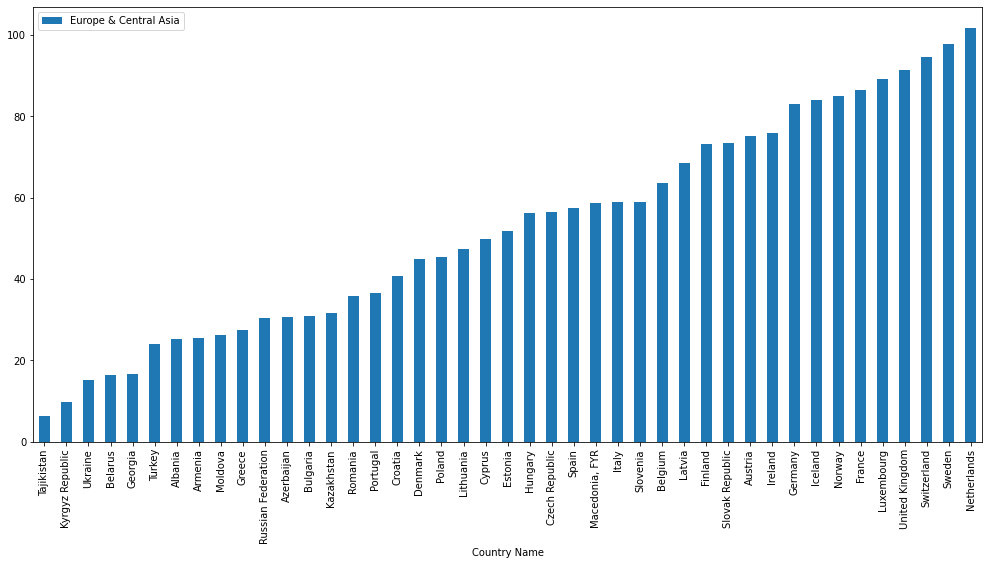

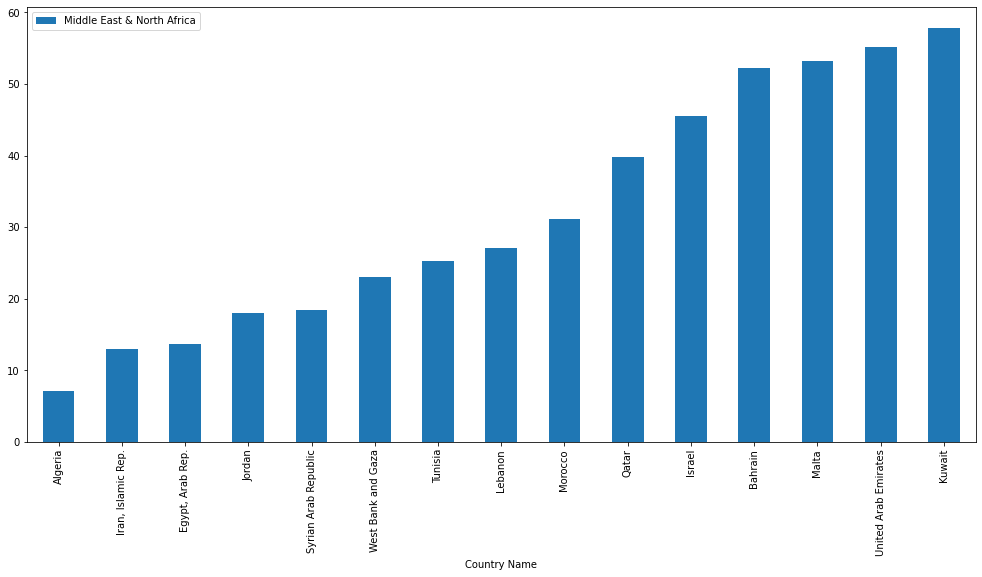

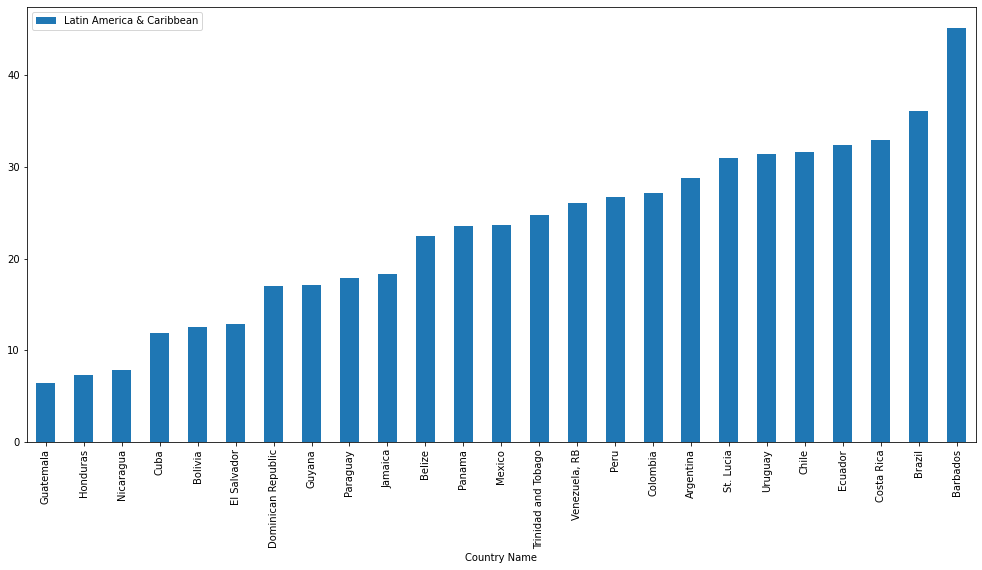

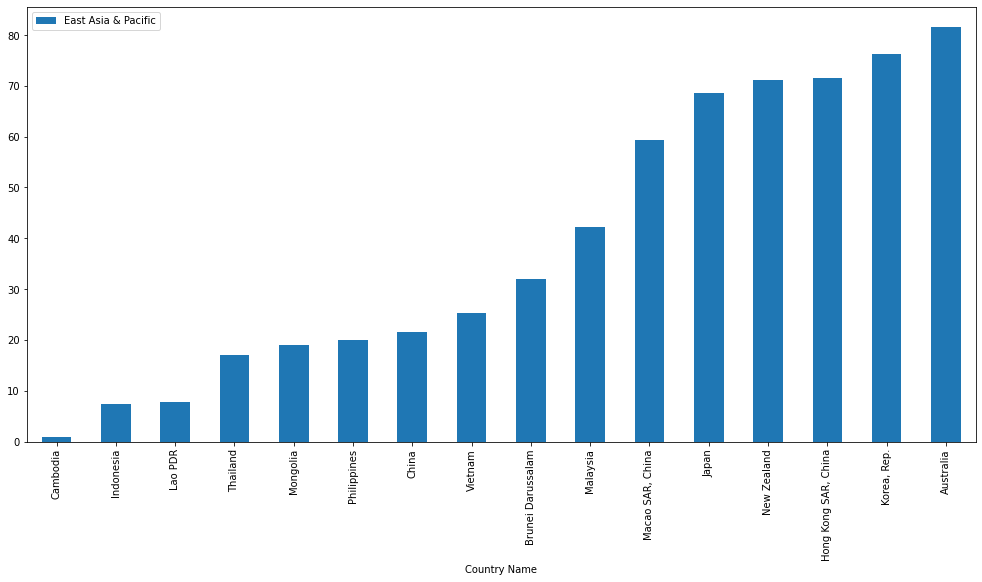

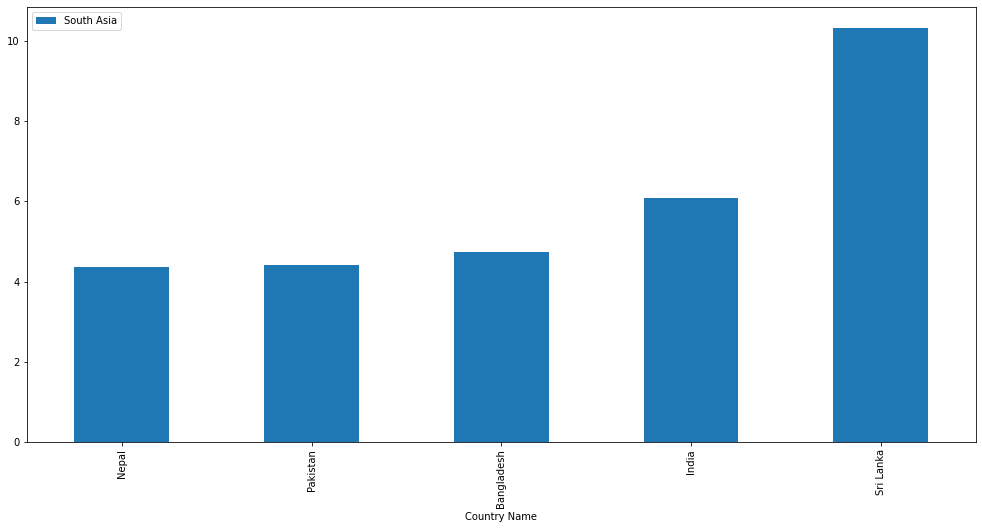

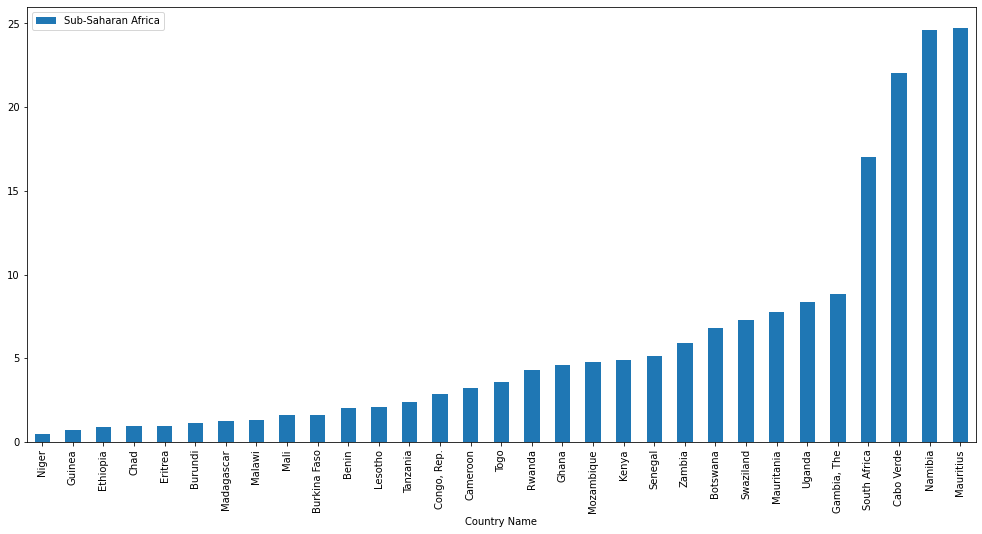

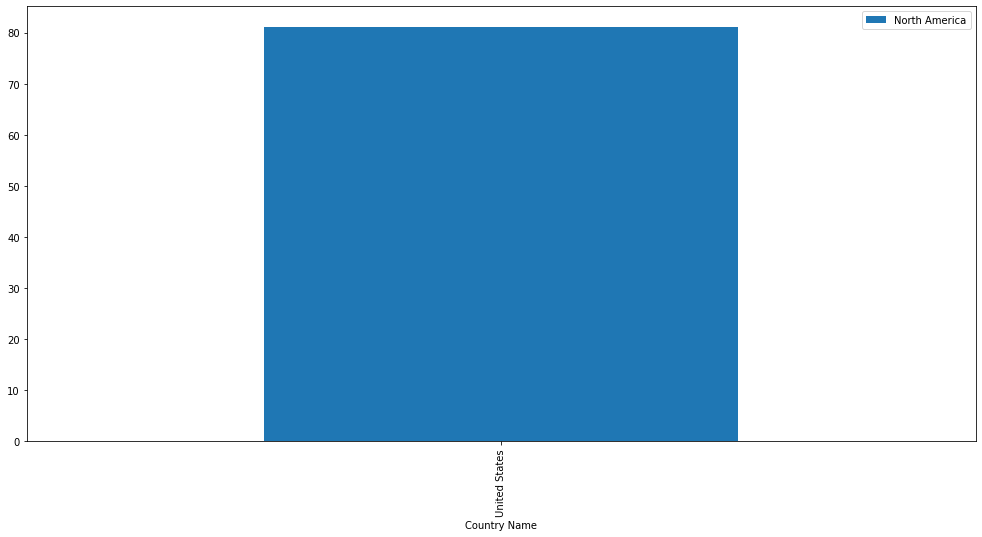

In [99]:
# % de internet & PC perso par région du monde en 2010

for i in Access_ind["Region"].unique():
    Access_ind[Access_ind["Region"]==i][['Region','Country Name','2000','2005','2010']].sort_values(
        by=['2010','2005','2000']).plot.bar(x="Country Name", y="2010", label=i, figsize=(17, 8))

plt.legend()
plt.show()

#### Indicateur 1 d'Infrastructure/Accessibilité 
Ce premier indicateur va donner des informations en 2005, voir l'état de l'infrastructure/l'accessibilité à un point T.Ici, le choix de 2005 n'est pas anodin, elle correspond à la date, où on a le plus de donnée. 2010/2015 aurait pu être pris mais, elle se base principalement sur des données interpolés ou avec beaucoup de données manquantes.

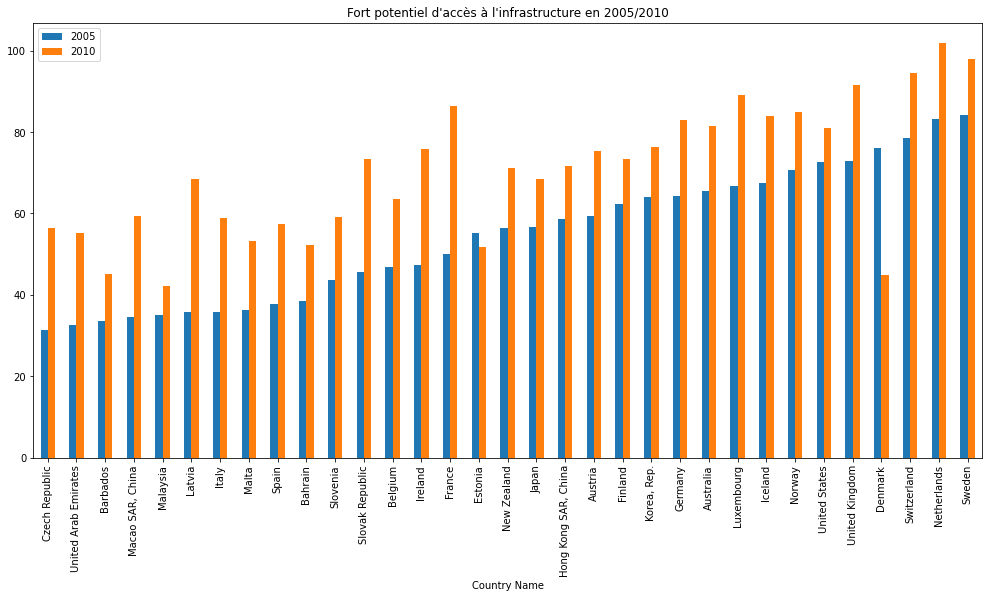

In [100]:
#Access_ind.set_index("Country Name", inplace=True)
Access_ind[Access_ind['2005']>30][['Country Name','2005',"2010"]].sort_values(by='2005').plot(kind='bar', x="Country Name", figsize=(17, 8), title="Fort potentiel d'accès à l'infrastructure en 2005/2010")

#### Indicateur 2 d'Infrastructure/Accessibilité   => Abandonnée
Elle correspond à evolution entre 1995 et 2010, ainsi de voir quels sont les pays ayant une forte potentiel d'evolution,ce indicateur est remplacer par l'indicateur suivant qui donne une meilleur aspect du potentiel d'evolution d'un pays.

In [101]:
'''
d = {'Country Name':Access_ind["Country Name"] , 'Pourcentage Evolution': (Access_ind['2010']-Access_ind['1995'])}
evolution_infra = pd.DataFrame(data=d)
evolution_infra_40=evolution_infra[evolution_infra['Pourcentage Evolution']>40]
evolution_infra_40.sort_values(by='Pourcentage Evolution').plot(kind='bar', x="Country Name", figsize=(17, 8), title="Fort potentiel d'evolution entre 1995 et 2010")
'''

'\nd = {\'Country Name\':Access_ind["Country Name"] , \'Pourcentage Evolution\': (Access_ind[\'2010\']-Access_ind[\'1995\'])}\nevolution_infra = pd.DataFrame(data=d)\nevolution_infra_40=evolution_infra[evolution_infra[\'Pourcentage Evolution\']>40]\nevolution_infra_40.sort_values(by=\'Pourcentage Evolution\').plot(kind=\'bar\', x="Country Name", figsize=(17, 8), title="Fort potentiel d\'evolution entre 1995 et 2010")\n'

#### Indicateur 3 d'Infrastructure/Accessibilité   
Ce indicateur correspond à l'evolution entré chaque année de l'indicateur d'accessiblité.  
Elle est calculé à partir de la moyenne entre la médiane et la moyenne des écarts.  
Elle donne ainsi une moyenne d'evolution entre chaque année pour un pays.  
Elle prend en entré une ligne(qui represente une pays) du dataset.

In [102]:
#Moyenne de l'evolution inter-années sur les 5 dernieres années

def evol_inter_year_last5(row):
    
    print(row.iloc[0])
    mylist=[]
    
    for x in range(2,row.size-1):
        mylist.append(np.divide(row.iloc[x],row.iloc[x-1]))
        
   
    print(mylist[-5:], sep='\n')
    print("\n")
    mean=sum(mylist[-5:]) / 5
    print("mean :", mean )
    #print("max :", max(mylist))
    #print("median :", statistics.median(mylist))
    #print("\n")
    return mean#(statistics.median(mylist)+mean)/2

In [103]:
#Essai sur le premier pays Albania
evol_inter_year_last5(Access_ind.iloc[0])

Albania
[1.088744178835756, 1.1115879635969643, 1.0495379928906974, 1.052741577423396, 1.0538397794940166]


mean : 1.071290298448166


1.071290298448166

In [104]:
infra=pd.DataFrame(data={'Country Name':Access_ind["Country Name"] , '2015': Access_ind['2015'] })
infra["indice_evolution"]=Access_ind.apply(evol_inter_year_last5, axis=1)

Albania
[1.088744178835756, 1.1115879635969643, 1.0495379928906974, 1.052741577423396, 1.0538397794940166]


mean : 1.071290298448166
Algeria
[1.1786679707446768, 1.2047945419201065, 1.2190553126499606, 1.288379585646184, 1.2769463965447028]


mean : 1.2335687615011262
Argentina
[1.1164295466418175, 1.0856172988270176, 1.0688330964498685, 1.0737861539611244, 1.0505229849827864]


mean : 1.079037816172523
Armenia
[1.200583611563521, 1.1426004375300383, 1.1090974589936045, 1.2055109457252353, 1.0824466685222074]


mean : 1.1480478244669212
Australia
[1.0449392797802248, 1.019667135497844, 1.047737913730402, 1.024092339238127, 1.0236007679254888]


mean : 1.0320074872344172
Austria
[1.043161032169188, 1.0268452157411212, 1.0217916155086537, 1.0200405376477155, 1.0349338419787966]


mean : 1.029354448609095
Azerbaijan
[1.1268280574759122, 1.1154412381084784, 1.292504010465876, 1.0580369433542445, 1.054853135456148]


mean : 1.1295326769721319
Bahrain
[1.1993047491607502, 1.0783873475163357

**Indicateur de Population**

In [105]:
Pop=Data[(Data["Indicator Code"]=="SP.POP.TOTL")]
Pop.set_index("Country Name", inplace=True)
Pop_ind=last_value(Pop, option=1)
Pop_ind

last_i       last_v
Country Name                            
Albania                2015   2.8807e+06
Algeria                2015  3.98715e+07
Argentina              2015  4.34178e+07
Armenia                2015  2.91695e+06
Australia              2015  2.37893e+07
Austria                2015  8.63317e+06
Azerbaijan             2015  9.64934e+06
Bahrain                2015  1.37186e+06
Bangladesh             2015  1.61201e+08
Barbados               2015       284217
Belarus                2015  9.48962e+06
Belgium                2015  1.12742e+07
Belize                 2015       359288
Benin                  2015   1.0576e+07
Bolivia                2015  1.07247e+07
Botswana               2015   2.2092e+06
Brazil                 2015  2.05962e+08
Brunei Darussalam      2015       417542
Bulgaria               2015  7.17799e+06
Burkina Faso           2015  1.81106e+07
Burundi                2015  1.01993e+07
Cabo Verde             2015       532913
Cambodia               2015  1.55176e+07
Cameroon               2015  2.28345e+07
Chad                   2015  1.40094e+07
Chile                  2015  1.77627e+07
China                  2015  1.37122e+09
Colombia               2015  4.82287e+07
Congo, Rep.            2015  4.99565e+06
Costa Rica             2015  4.80785e+06
Cote d'Ivoire          2015  2.31085e+07
Croatia                2015   4.2036e+06
Cuba                   2015  1.14614e+07
Cyprus                 2015  1.16098e+06
Czech Republic         2015  1.05461e+07
Denmark                2015  5.68348e+06
Dominican Republic     2015  1.05284e+07
Ecuador                2015  1.61444e+07
Egypt, Arab Rep.       2015  9.37782e+07
El Salvador            2015  6.31248e+06
Eritrea                2011  4.47469e+06
Estonia                2015  1.31541e+06
Ethiopia               2015   9.9873e+07
Finland                2015  5.47953e+06
France                 2015  6.66241e+07
Gambia, The            2015  1.97759e+06
Georgia                2015   3.7171e+06
Germany                2015  8.16866e+07
Ghana                  2015  2.75828e+07
Greece                 2015  1.08209e+07
Guatemala              2015  1.62524e+07
Guinea                 2015  1.20915e+07
Guyana                 2015       768514
Honduras               2015  8.96083e+06
Hong Kong SAR, China   2015   7.3057e+06
Hungary                2015  9.84303e+06
Iceland                2015       330815
India                  2015  1.30905e+09
Indonesia              2015  2.58162e+08
Iran, Islamic Rep.     2015  7.93605e+07
Ireland                2015  4.67684e+06
Israel                 2015   8.3801e+06
Italy                  2015  6.07306e+07
Jamaica                2015  2.87193e+06
Japan                  2015  1.27141e+08
Jordan                 2015   9.1593e+06
Kazakhstan             2015  1.75441e+07
Kenya                  2015  4.72363e+07
Korea, Rep.            2015  5.10149e+07
Kuwait                 2015  3.93579e+06
Kyrgyz Republic        2015   5.9569e+06
Lao PDR                2015  6.66397e+06
Latvia                 2015  1.97753e+06
Lebanon                2015  5.85148e+06
Lesotho                2015  2.17464e+06
Lithuania              2015  2.90491e+06
Luxembourg             2015       569604
Macao SAR, China       2015       600942
Macedonia, FYR         2015  2.07931e+06
Madagascar             2015  2.42341e+07
Malawi                 2015  1.75736e+07
Malaysia               2015  3.07232e+07
Mali                   2015  1.74679e+07
Malta                  2015       431874
Mauritania             2015  4.18234e+06
Mauritius              2015  1.26260e+06
Mexico                 2015  1.25891e+08
Moldova                2015  3.55411e+06
Mongolia               2015  2.97688e+06
Morocco                2015  3.48033e+07
Mozambique             2015  2.80107e+07
Namibia                2015  2.42556e+06
Nepal                  2015  2.86563e+07
Netherlands            2015  1.69399e+07
New Zealand            2015   4.5957e+06
Nicaragua              2015  6.08204e+06
Nig

In [106]:
Pop_ind["last_v"]

Country Name
Albania                  2.8807e+06
Algeria                 3.98715e+07
Argentina               4.34178e+07
Armenia                 2.91695e+06
Australia               2.37893e+07
Austria                 8.63317e+06
Azerbaijan              9.64934e+06
Bahrain                 1.37186e+06
Bangladesh              1.61201e+08
Barbados                     284217
Belarus                 9.48962e+06
Belgium                 1.12742e+07
Belize                       359288
Benin                    1.0576e+07
Bolivia                 1.07247e+07
Botswana                 2.2092e+06
Brazil                  2.05962e+08
Brunei Darussalam            417542
Bulgaria                7.17799e+06
Burkina Faso            1.81106e+07
Burundi                 1.01993e+07
Cabo Verde                   532913
Cambodia                1.55176e+07
Cameroon                2.28345e+07
Chad                    1.40094e+07
Chile                   1.77627e+07
China                   1.37122e+09
Colombia       

#### Indicateur Final d'Infrastructure/Accessibilité   
l'indicateur final d'accessibilité/d'infrastructure prend la forme d'une fonction à croissance exponentielle y=a*(b^p), avec a la valeur de base, b le potentiel d'évolution et p le nb d'année.  
Dans notre cas, a= valeur de 2005, b= potentiel d'evolution inter-année et p=5ans, elle n'a pas été étendu plus loin afin de garder des valeur proche des valeurs réelles. Plus on avance dans le temps, plus cela devient imprecis.    
A contrario plus tard, un filtre sera placé sur cette indicateur afin de recupérer uniquement les pays ayant un indicateur supérieur à 50% => des pays interessants ou à fort potentiel.

In [107]:
infra["infra_2020"]=(infra["indice_evolution"]**5)*infra["2015"]
#infra["infra_2020"]=infra["infra_2020"].apply(lambda x: 100 if x>=100 else x)
infra.set_index("Country Name", inplace=True)
infra["infra_2020_valeur"]=((infra["infra_2020"]/100)*Pop_ind["last_v"])/1000000
#infra["infra_2020_valeur"]=infra["infra_2020_valeur"].apply(lambda x: 100 if x>=100 else x)
infra.dropna(axis=0, inplace=True)

In [108]:
infra.sort_values(by="infra_2020_valeur")

2015  indice_evolution  infra_2020  \
Country Name                                                     
Denmark                 3.802418          0.646547    0.429598   
St. Lucia              31.702338          1.006396   32.729230   
Eritrea                 1.704986          1.119802    3.002111   
Belize                 29.898646          1.059601   39.935816   
Guyana                 19.426707          1.026180   22.106344   
Barbados               56.020832          1.044053   69.496502   
Brunei Darussalam      41.985013          1.056313   55.215081   
Cabo Verde             30.903229          1.070384   43.421243   
Congo, Rep.             4.292999          1.083477    6.410022   
Trinidad and Tobago    24.916996          1.001458   25.099209   
Malta                  65.668347          1.043332   81.183784   
Iceland                99.815686          1.035075  118.592843   
Swaziland              14.491198          1.158648   30.259539   
Chad                    1.852740          1.145644    3.656469   
Gambia, The            16.521051          1.133063   30.853721   
Luxembourg            104.686092          1.032654  122.931243   
Mauritius              37.569718          1.087867   57.242191   
Macao SAR, China       85.082909          1.075017  122.157326   
Niger                   1.301206          1.236621    3.762959   
Togo                    6.086080          1.111307   10.315924   
Estonia                62.981949          1.040086   76.658846   
Cyprus                 68.803866          1.067172   95.232498   
Jamaica                26.679732          1.084109   39.952641   
Bahrain                68.525982          1.058416   91.019896   
Burundi                 3.288937          1.302806   12.343966   
Mongolia               28.337303          1.084136   42.440140   
Madagascar              2.592719          1.159613    5.436519   
Tajikistan             10.111476          1.095984   15.989496   
Nicaragua              13.467117          1.115827   23.294751   
Albania                35.630181          1.071290   50.275209   
Qatar                  48.109951          1.041689   59.009940   
Slovenia               65.207225          1.020334   72.111889   
Panama                 30.555029          1.054273   39.796769   
Mauritania             17.837374          1.182832   41.299592   
Georgia                27.830679          1.109548   46.800873   
Lesotho                12.672730          1.449036   80.959213   
Namibia                43.043262          1.119140   75.566126   
Kyrgyz Republic        17.364537          1.123114   31.030106   
Uruguay                42.048049          1.059858   56.232160   
Botswana               24.311550          1.303706   91.561252   
El Salvador            20.309221          1.096365   32.171347   
Benin                   6.359635          1.273039   21.263830   
Lithuania              60.884380          1.051084   78.107721   
West Bank and Gaza     34.625902          1.085351   52.149821   
Lao PDR                16.667951          1.167004   36.078170   
Croatia                49.753480          1.041060   60.841936   
Latvia                 95.464217          1.068691  133.076787   
Rwanda                  9.532331          1.195042   23.233470   
Armenia                50.681057          1.148048  101.075423   
Moldova                47.134606          1.126909   85.661070   
Macedonia, FYR         92.950298          1.096219  147.142249   
Guinea                  4.338987          1.431882   26.117062   
Bolivia                19.287363          1.096960   30.635560   
Costa Rica             47.686287          1.077873   69.379635   
Malawi                  4.933114          1.310679   19.081064   
Honduras               16.823020          1.191133   40.337121   
Zambia                 11.725505          1.147898   23.369398   
Lebanon                42.263582          1.095155   66.579981   
Bulgaria               41.366275          1.060795   55.565242   
Ne

In [109]:
4.48554e+10

44855400000.0

### Topic Scolaire  

Nous allons maintenant travailler sur la mise en place d'indicateur scolaire.  
Nous allons se baser principalement sur plusieurs indicateurs :
- Entrée Collège
- Entrée Lycée
- Entrée Université
- Ratio Prof-Eleve Secondaire
- Ratio Prof-Eleve Université

Pour construire les indicateurs scolaires, nous allons principalement nous servir de la année disponible (principalement entre  2010 et 2015)

In [110]:
data_merge_series[data_merge_series["Topic"]=="Secondary"].groupby(["Indicator Code","Indicator Name"]).count()

Country Name  \
Indicator Code          Indicator Name                                                                                                           
SE.ENR.PRSC.FM.ZS       Gross enrolment ratio, primary and secondary, gender parity index (GPI)                                            137   
SE.ENR.SECO.FM.ZS       Gross enrolment ratio, secondary, gender parity index (GPI)                                                        137   
SE.SEC.AGES             Official entrance age to lower secondary education (years)                                                         137   
SE.SEC.CMPT.LO.FE.ZS    Lower secondary completion rate, female (%)                                                                        137   
SE.SEC.CMPT.LO.MA.ZS    Lower secondary completion rate, male (%)                                                                          137   
SE.SEC.CMPT.LO.ZS       Lower secondary completion rate, both sexes (%)                                                                    137   
SE.SEC.DURS             Theoretical duration of secondary education (years)                                                                137   
SE.SEC.DURS.UP          Theoretical duration of upper secondary education (years)                                                          137   
SE.SEC.ENRL             Enrolment in secondary education, both sexes (number)                                                              137   
SE.SEC.ENRL.FE          Enrolment in secondary education, female (number)                                                                  137   
SE.SEC.ENRL.FE.VO.ZS    Percentage of female students in secondary education enrolled in vocational programmes, female (%)                 137   
SE.SEC.ENRL.FE.ZS       Percentage of students in secondary education who are female (%)                                                   137   
SE.SEC.ENRL.GC          Enrolment in secondary general, both sexes (number)                                                                137   
SE.SEC.ENRL.GC.FE       Enrolment in secondary general, female (number)                                                                    137   
SE.SEC.ENRL.GC.FE.ZS    Percentage of students in secondary general education who are female (%)                                           137   
SE.SEC.ENRL.MA.VO.ZS    Percentage of male students in secondary education enrolled in vocational programmes, male (%)                     137   
SE.SEC.ENRL.VO          Enrolment in secondary vocational, both sexes (number)                                                             137   
SE.SEC.ENRL.VO.FE       Enrolment in secondary vocational, female (number)                                                                 137   
SE.SEC.ENRL.VO.FE.ZS    Percentage of students in secondary vocational education who are female (%)                                        137   
SE.SEC.ENRL.VO.ZS       Percentage of students in secondary education enrolled in vocational programmes, both sexes (%)                    137   
SE.SEC.ENRR             Gross enrolment ratio, secondary, both sexes (%)                                                                   137   
SE.SEC.ENRR.FE          Gross enrolment ratio, secondary, female (%)                                                                       137   
SE.SEC.ENRR.LO          Gross enrolment ratio, lower secondary, both sexes (%)                                                             137   
SE.SEC.ENRR.LO.FE       Gross enrolment ratio, lower secondary, female (%)                                                                 137   
SE.SEC.ENRR.LO.MA       Gross enrolment ratio, lower secondary, male (%)                                                                   137   
SE.SEC.ENRR.MA          Gross enrolment ratio, secondary, male (%)                                                                         137   
SE.SEC.ENRR.UP          Gross enrolment ra

In [111]:
#liste=[#"UIS.NERA.2",  # Adjusted net enrolment rate, lower secondary, both sexes (%) => Pauvreté
#"SE.SEC.ENRR.LO",  #Gross enrolment ratio, lower secondary, both sexes (%) ***
#"UIS.GER.12",
#"SE.SEC.ENRR", #Gross enrolment ratio, secondary, both sexes 
#"SE.SEC.ENRR.UP", #Gross enrolment ratio, upper secondary, both sexes ***
#"SE.SEC.CMPT.LO.ZS", #Lower secondary completion rate, both sexes ***
#"SE.SEC.NENR", # Net enrolment rate, secondary, both sexes 
#"UIS.GTVP.2.GPV",
#"UIS.GTVP.23.GPV", #General
#"UIS.GTVP.3.GPV",
#"UIS.NERT.2"] #Total net enrolment rate, lower secondary, both sexes (%) => Pauvreté du pays

In [112]:
data_merge_series[(data_merge_series["Indicator Code"]=="SE.SEC.CMPT.LO.ZS")].isna().sum()

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1990               85
1991               84
1992               84
1993               84
1994               77
1995               86
1996               90
1997               95
1998              117
1999               68
2000               63
2001               54
2002               45
2003               51
2004               43
2005               42
2006               42
2007               42
2008               36
2009               31
2010               36
2011               36
2012               38
2013               34
2014               37
2015               50
Topic               0
Region              0
Income Group        0
dtype: int64

In [113]:
data_merge_series.set_index("Country Name", inplace=True)

In [114]:
complt_ind=data_merge_series[(data_merge_series["Indicator Code"]=="SE.SEC.CMPT.LO.ZS")]#[["2010","2011","2012","2013","2014","2015"]]

**Indicateur entré en dernier année college => abandonnée**

In [115]:
last_complt_ind=last_value(complt_ind)
print(last_complt_ind.sort_values(by="last_v"))

                     last_i   last_v
Country Name                        
Niger                  2015   15.676
Chad                   2013   17.507
Malawi                 2013  21.0385
Mozambique             2015   22.165
Uganda                 2015  25.8514
Burkina Faso           2015  26.9976
Ethiopia               2015  29.6785
Mali                   2015  30.5029
Eritrea                2015   31.037
Mauritania             2015  31.4694
Burundi                2015  32.3199
Rwanda                 2015  33.5599
Cote d'Ivoire          2015  35.0145
Guinea                 2014  35.0683
Tanzania               2013  35.1328
Madagascar             2015  37.8249
Senegal                2015  38.9009
Togo                   2015  41.0559
Swaziland              2014  41.2099
Lesotho                2014  42.8637
Benin                  2015  43.6139
Cameroon               2015  45.5544
Bulgaria               2015  45.9735
Cambodia               2015  47.9987
Syrian Arab Republic   2013  51.4267
C

**Indicateur taux entrée au college**

In [116]:
ent_lo_ind=data_merge_series[(data_merge_series["Indicator Code"]=="SE.SEC.ENRR.LO")]
last_ent_lo_ind=last_value(ent_lo_ind)
#last_ent_lo_ind["nombre"]=
print(last_ent_lo_ind)#.sort_values(by="last_v"))

                     last_i   last_v
Country Name                        
Albania                2015  101.488
Algeria                2011   132.01
Argentina              2014  127.716
Armenia                2015   87.569
Australia              2014  111.988
Austria                2015  100.457
Azerbaijan             2015  90.5404
Bahrain                2015  101.486
Bangladesh             2015  83.4492
Barbados               2014  106.872
Belarus                2015   102.42
Belgium                2015  184.538
Belize                 2015  91.0718
Benin                  2015   69.778
Bolivia                2015  96.4894
Botswana               2013  91.4688
Brazil                 2015  106.366
Brunei Darussalam      2015   104.84
Bulgaria               2015  89.9173
Burkina Faso           2015   47.057
Burundi                2015  54.4397
Cabo Verde             2015   114.61
Cambodia               2015  62.7148
Cameroon               2015  68.0556
Chad                   2012  26.0369
C

**Indicateur valeur entrée au college** => abandonnée

In [117]:
ent_lo_ind_v=data_merge_series[(data_merge_series["Indicator Code"]=="UIS.E.2")]
last_ent_lo_ind_v=last_value(ent_lo_ind_v)
last_ent_lo_ind_v

last_i       last_v
Country Name                            
Albania                2014       181354
Algeria                2011  3.23993e+06
Argentina              2013  2.68335e+06
Armenia                2014       141158
Australia              2014  1.26712e+06
Austria                2014       334201
Azerbaijan             2014       576653
Bahrain                2014        45992
Bangladesh             2013  7.52936e+06
Barbados               2014        12193
Belarus                2014       447641
Belgium                2014       433699
Belize                 2014        28197
Benin                  2014       665513
Bolivia                2013       447350
Botswana               2013       120598
Brazil                 2013  1.49318e+07
Brunei Darussalam      2014        14918
Bulgaria               2014       232110
Burkina Faso           2014       699132
Burundi                2014       450020
Cabo Verde             2014        35690
Cambodia               2014       556395
Cameroon               2014  1.40029e+06
Chad                   2012       321921
Chile                  2014       524331
China                  2014  4.49826e+07
Colombia               2014  3.49334e+06
Congo, Rep.            2012       243984
Costa Rica             2014       298775
Cote d'Ivoire          2014  1.04715e+06
Croatia                2014       184005
Cuba                   2014       413784
Cyprus                 2014        27837
Czech Republic         2014       367021
Denmark                2014       242432
Dominican Republic     2014       350733
Ecuador                2014  1.04953e+06
Egypt, Arab Rep.       2014  4.81412e+06
El Salvador            2014       386275
Eritrea                2013       155526
Estonia                2013        36946
Ethiopia               2014  4.01506e+06
Finland                2014       179375
France                 2014  3.34886e+06
Gambia, The            2014        87391
Georgia                2014       141416
Germany                2014  4.62112e+06
Ghana                  2015  1.59128e+06
Greece                 2013       323909
Guatemala              2014       769163
Guinea                 2014       487331
Guyana                 2012        55606
Honduras               2014       396318
Hong Kong SAR, China   2014       190534
Hungary                2014       386602
Iceland                2012        12978
India                  2013  6.41719e+07
Indonesia              2014  1.26843e+07
Iran, Islamic Rep.     2014   2.1027e+06
Ireland                2013       189543
Israel                 2014       398413
Italy                  2013  1.81386e+06
Jamaica                2014       136060
Japan                  2013  3.59784e+06
Jordan                 2012       510578
Kazakhstan             2015  1.20933e+06
Kenya                  2014  2.09321e+06
Korea, Rep.            2013  1.81627e+06
Kuwait                 2012       165521
Kyrgyz Republic        2014       472262
Lao PDR                2014       421252
Latvia                 2014        54825
Lebanon                2013       219092
Lesotho                2014        93109
Lithuania              2014       190914
Luxembourg             2013        21847
Macao SAR, China       2014        15399
Macedonia, FYR         2012        92559
Madagascar             2014  1.15167e+06
Malawi                 2014       755942
Malaysia               2014  1.47488e+06
Mali                   2014       647186
Malta                  2014        12812
Mauritania             2014       128153
Mauritius              2014        65176
Mexico                 2014  8.31099e+06
Moldova                2014       166785
Mongolia               2014       164633
Morocco                2014  1.65715e+06
Mozambique             2014       620253
Namibia                2013       147262
Nepal                  2015  1.83531e+06
Netherlands            2014       827583
New Zealand            2014       242303
Nicaragua              2010       319539
Nig

**Indicateur taux entrée au lycée**

In [118]:
ent_up_ind=data_merge_series[(data_merge_series["Indicator Code"]=="SE.SEC.ENRR.UP")]
last_ent_up_ind=last_value(ent_up_ind)
print(last_ent_up_ind.sort_values(by="last_v"))

                     last_i   last_v
Country Name                        
Tanzania               2013  9.00075
Niger                  2015  10.3627
Burkina Faso           2015  13.4207
Uganda                 2008   14.127
Chad                   2013  17.6757
Ethiopia               2015    17.68
Mauritania             2015  21.0525
Mozambique             2015  21.4213
Madagascar             2014  21.5842
Malawi                 2015  22.1611
Eritrea                2015  23.0797
Burundi                2015  25.4692
Cote d'Ivoire          2015   27.757
Cambodia               2008  28.6332
Mali                   2015  29.1897
Guinea                 2014  30.7243
Rwanda                 2015  31.2229
Syrian Arab Republic   2013  31.5121
Vietnam                1998  32.1876
Pakistan               2015  35.4466
Togo                   2011  35.7883
Senegal                2015  36.0648
Namibia                2007  36.2197
Benin                  2015  37.5879
Congo, Rep.            2012  38.2802
G

**Indicateur valeur entrée au lycée**

In [119]:
ent_up_ind_v=data_merge_series[(data_merge_series["Indicator Code"]=="UIS.E.3")]
last_ent_up_ind_v=last_value(ent_up_ind_v)
last_ent_up_ind_v

last_i       last_v
Country Name                            
Albania                2014       151937
Algeria                2011  1.33258e+06
Argentina              2013   1.7227e+06
Armenia                2014       103385
Australia              2014  1.10416e+06
Austria                2014       363188
Azerbaijan             2014       372641
Bahrain                2014        44100
Bangladesh             2013  5.78471e+06
Barbados               2014         8410
Belarus                2014       200900
Belgium                2014       776413
Belize                 2014         8898
Benin                  2014       231250
Bolivia                2013       665372
Botswana               2013        63882
Brazil                 2013  9.94958e+06
Brunei Darussalam      2014        34091
Bulgaria               2014       286804
Burkina Faso           2014       142754
Burundi                2014       133288
Cabo Verde             2014        24133
Cambodia               2008       285750
Cameroon               2014       599790
Chad                   2013       148229
Chile                  2014  1.03204e+06
China                  2014  4.37092e+07
Colombia               2014  1.33462e+06
Congo, Rep.            2012        95266
Costa Rica             2014       161460
Cote d'Ivoire          2014       371207
Croatia                2014       186351
Cuba                   2014       416591
Cyprus                 2014        30797
Czech Republic         2014       414371
Denmark                2014       311359
Dominican Republic     2014       580335
Ecuador                2014       828133
Egypt, Arab Rep.       2014  3.39421e+06
El Salvador            2014       238785
Eritrea                2013       113108
Estonia                2013        43894
Ethiopia               2012       524927
Finland                2014       357550
France                 2014  2.59836e+06
Gambia, The            2010        48999
Georgia                2014       140323
Germany                2014  2.57995e+06
Ghana                  2015       848222
Greece                 2013       371024
Guatemala              2014       396461
Guinea                 2014       228371
Guyana                 2012        30328
Honduras               2014       223514
Hong Kong SAR, China   2014       225437
Hungary                2014       471205
Iceland                2012        23149
India                  2013  5.52287e+07
Indonesia              2014  9.90266e+06
Iran, Islamic Rep.     2014  3.69184e+06
Ireland                2012       150905
Israel                 2014       369316
Italy                  2013  2.78044e+06
Jamaica                2014        87860
Japan                  2013  3.68292e+06
Jordan                 2012       213778
Kazakhstan             2015       469946
Kenya                  2012  1.91482e+06
Korea, Rep.            2013  1.90386e+06
Kuwait                 2012       108681
Kyrgyz Republic        2014       178254
Lao PDR                2014       179495
Latvia                 2014        66755
Lebanon                2013       170262
Lesotho                2014        37727
Lithuania              2014        86435
Luxembourg             2013        24409
Macao SAR, China       2014        16655
Macedonia, FYR         2012        93590
Madagascar             2014       342159
Malawi                 2014       164267
Malaysia               2014  1.56305e+06
Mali                   2014       313860
Malta                  2014        17418
Mauritania             2014        50815
Mauritius              2014        67825
Mexico                 2014  4.68234e+06
Moldova                2014        78988
Mongolia               2014       120964
Morocco                2013       983515
Mozambique             2014       163305
Namibia                2007        33714
Nepal                  2015  1.34101e+06
Netherlands            2014       746415
New Zealand            2014       249314
Nicaragua              2010       145662
Nig

In [120]:
data_merge_series[(data_merge_series["Indicator Code"]=="UIS.E.3")]

Country Code  \
Country Name                        
Albania                       ALB   
Algeria                       DZA   
Argentina                     ARG   
Armenia                       ARM   
Australia                     AUS   
Austria                       AUT   
Azerbaijan                    AZE   
Bahrain                       BHR   
Bangladesh                    BGD   
Barbados                      BRB   
Belarus                       BLR   
Belgium                       BEL   
Belize                        BLZ   
Benin                         BEN   
Bolivia                       BOL   
Botswana                      BWA   
Brazil                        BRA   
Brunei Darussalam             BRN   
Bulgaria                      BGR   
Burkina Faso                  BFA   
Burundi                       BDI   
Cabo Verde                    CPV   
Cambodia                      KHM   
Cameroon                      CMR   
Chad                          TCD   
Chile                         CHL   
China                         CHN   
Colombia                      COL   
Congo, Rep.                   COG   
Costa Rica                    CRI   
Cote d'Ivoire                 CIV   
Croatia                       HRV   
Cuba                          CUB   
Cyprus                        CYP   
Czech Republic                CZE   
Denmark                       DNK   
Dominican Republic            DOM   
Ecuador                       ECU   
Egypt, Arab Rep.              EGY   
El Salvador                   SLV   
Eritrea                       ERI   
Estonia                       EST   
Ethiopia                      ETH   
Finland                       FIN   
France                        FRA   
Gambia, The                   GMB   
Georgia                       GEO   
Germany                       DEU   
Ghana                         GHA   
Greece                        GRC   
Guatemala                     GTM   
Guinea                        GIN   
Guyana                        GUY   
Honduras                      HND   
Hong Kong SAR, China          HKG   
Hungary                       HUN   
Iceland                       ISL   
India                         IND   
Indonesia                     IDN   
Iran, Islamic Rep.            IRN   
Ireland                       IRL   
Israel                        ISR   
Italy                         ITA   
Jamaica                       JAM   
Japan                         JPN   
Jordan                        JOR   
Kazakhstan                    KAZ   
Kenya                         KEN   
Korea, Rep.                   KOR   
Kuwait                        KWT   
Kyrgyz Republic               KGZ   
Lao PDR                       LAO   
Latvia                        LVA   
Lebanon                       LBN   
Lesotho                       LSO   
Lithuania                     LTU   
Luxembourg                    LUX   
Macao SAR, China              MAC   
Macedonia, FYR                MKD   
Madagascar                    MDG   
Malawi                        MWI   
Malaysia                      MYS   
Mali                          MLI   
Malta                         MLT   
Mauritania                    MRT   
Mauritius                     MUS   
Mexico                        MEX   
Moldova                       MDA   
Mongolia                      MNG   
Morocco                       MAR   
Mozambique                    MOZ   
Namibia                       NAM   
Nepal                         NPL   
Netherlands                   NLD   
New Zealand                   NZL   
Nicaragua                     NIC   
Niger                         NER   
Norway                        NOR   
Pakistan                      PAK   
Panama                        PAN   
Paraguay                      PRY   
Peru                          PER   
Philippines                   PHL   
Poland                        POL   
Portugal                      PRT   
Qatar                         QAT   
Romania                  

**Indicateur taux entrée à l'université**

In [121]:
ent_uni_ind=data_merge_series[(data_merge_series["Indicator Code"]=="SE.TER.ENRR")]
last_ent_uni_ind=last_value(ent_uni_ind)
print(last_ent_uni_ind.sort_values(by="last_v"))

                     last_i   last_v
Country Name                        
Malawi                 2011  0.79773
Niger                  2012  1.71459
Eritrea                2014  2.56538
Gambia, The            2012  3.10428
Chad                   2014  3.44539
Tanzania               2013  3.64732
Zambia                 2012  3.98141
Kenya                  2009  4.04682
Uganda                 2014  4.76082
Madagascar             2014  4.77556
Burkina Faso           2013  4.77591
Burundi                2014  4.96606
Swaziland              2013  5.32888
Mauritania             2015  5.62173
United Arab Emirates   1993  6.11316
Mozambique             2015  6.39052
Mali                   2012  6.87478
Rwanda                 2015  7.89708
Ethiopia               2014  8.12604
Cote d'Ivoire          2015  9.15527
Namibia                2008  9.33008
Congo, Rep.            2013   9.7188
Lesotho                2014   9.8422
Pakistan               2015  9.92739
Senegal                2015  10.3867
T

**Indicateur valeur entrée à l'université**

In [122]:
ent_uni_ind_v=data_merge_series[(data_merge_series["Indicator Code"]=="SE.TER.ENRL")]
last_ent_uni_ind_v=last_value(ent_uni_ind_v)
last_ent_uni_ind_v

last_i       last_v
Country Name                            
Albania                2015       160527
Algeria                2015  1.28947e+06
Argentina              2014  2.86945e+06
Armenia                2015       107665
Australia              2014  1.45352e+06
Austria                2015       425972
Azerbaijan             2015       204152
Bahrain                2015        38901
Bangladesh             2014  2.06836e+06
Barbados               2011        12421
Belarus                2015       477221
Belgium                2015       504745
Belize                 2015         8562
Benin                  2013       145464
Bolivia                2007       352554
Botswana               2015        60583
Brazil                 2015  8.28548e+06
Brunei Darussalam      2015        10866
Bulgaria               2015       278953
Burkina Faso           2013        74276
Burundi                2014        51225
Cabo Verde             2015        12538
Cambodia               2015       217364
Cameroon               2015       389974
Chad                   2014        42463
Chile                  2015  1.22177e+06
China                  2015  4.33674e+07
Colombia               2015  2.29355e+06
Congo, Rep.            2013        37037
Costa Rica             2015       217841
Cote d'Ivoire          2015       192689
Croatia                2015       162022
Cuba                   2015       261413
Cyprus                 2015        37166
Czech Republic         2015       395529
Denmark                2015       313756
Dominican Republic     2015       480103
Ecuador                2013       586105
Egypt, Arab Rep.       2015  2.86891e+06
El Salvador            2015       179396
Eritrea                2014        12554
Estonia                2015        55214
Ethiopia               2014       757175
Finland                2015       302478
France                 2014  2.38888e+06
Gambia, The            2012         5001
Georgia                2015       127633
Germany                2015  2.97778e+06
Ghana                  2015       417534
Greece                 2014       677429
Guatemala              2015       366674
Guinea                 2014       117943
Guyana                 2012         8857
Honduras               2015       195469
Hong Kong SAR, China   2015       298643
Hungary                2015       307729
Iceland                2013        19097
India                  2015  3.21074e+07
Indonesia              2015    5.108e+06
Iran, Islamic Rep.     2015  4.80272e+06
Ireland                2015       214632
Israel                 2015       374048
Italy                  2015  1.82648e+06
Jamaica                2015        74537
Japan                  2014  3.86246e+06
Jordan                 2015       312750
Kazakhstan             2015       658413
Kenya                  2009       167983
Korea, Rep.            2015   3.2681e+06
Kuwait                 2013        71786
Kyrgyz Republic        2015       265382
Lao PDR                2015       130191
Latvia                 2015        85881
Lebanon                2015       216468
Lesotho                2014        23545
Lithuania              2015       140629
Luxembourg             2012         6085
Macao SAR, China       2015        30771
Macedonia, FYR         2015        63543
Madagascar             2014       113025
Malawi                 2011        12203
Malaysia               2015       817587
Mali                   2012        97278
Malta                  2015        13216
Mauritania             2015        20800
Mauritius              2015        37871
Mexico                 2014  3.41939e+06
Moldova                2015       109395
Mongolia               2015       179540
Morocco                2015       877404
Mozambique             2015       174802
Namibia                2008        19707
Nepal                  2015       445324
Netherlands            2015       842601
New Zealand            2015       270074
Nicaragua              2002       100363
Nig

**Indicateur Ratio eleve/prof en secondaire** => abandonnée

In [123]:
ratio_pe_sec_ind=data_merge_series[(data_merge_series["Indicator Code"]=="SE.SEC.ENRL.TC.ZS")]
last_ratio_pe_sec_ind=last_value(ratio_pe_sec_ind)
print(last_ratio_pe_sec_ind.sort_values(by="last_v"))

                     last_i   last_v
Country Name                        
Ukraine                2015  6.97019
Croatia                2015  7.03333
Kuwait                 2015  7.20262
Georgia                2015  7.24706
Kazakhstan             2015  7.50668
Malta                  2015  7.51855
Lebanon                2014  7.74275
Lithuania              2015  7.88976
Latvia                 2015  8.03226
Estonia                2013  8.09777
Greece                 2014  8.30619
Belarus                2015  8.36258
Norway                 2015  8.51387
Russian Federation     2012  8.76378
Brunei Darussalam      2015  8.83654
Cuba                   2015  9.03784
Luxembourg             2014  9.11907
Switzerland            2012  9.32916
Moldova                2015  9.34236
Belgium                2014  9.42359
Poland                 2014  9.45976
Macedonia, FYR         2014  9.56464
Austria                2015  9.57663
Armenia                1996   9.7547
Bahrain                2015  9.86281
P

**Indicateur Ratio eleve/prof en université** => Abandonnée

In [124]:
ratio_pe_uni_ind=data_merge_series[(data_merge_series["Indicator Code"]=="UIS.PTRHC.56")]
last_ratio_pe_uni_ind=last_value(ratio_pe_uni_ind)
print(last_ratio_pe_uni_ind.sort_values(by="last_v"))

                     last_i   last_v
Country Name                        
Luxembourg             2012  3.75849
Cuba                   2015  4.59684
Lebanon                2014  4.98637
Armenia                2015  6.86902
Austria                2015  6.99524
Japan                  2014  7.08089
Uruguay                2015  7.08839
Georgia                2015  7.08954
Germany                2015  7.51542
Malta                  2015  7.95593
Denmark                2015  8.46297
Iceland                2012  8.71305
Switzerland            2014   8.8624
Cabo Verde             2015  9.17862
Azerbaijan             2015  9.70719
Trinidad and Tobago    2004  9.73895
Mexico                 2014  9.79227
Norway                 2015   9.9275
Croatia                2015  10.0504
St. Lucia              2015  10.1752
Malaysia               2015  10.1904
Cote d'Ivoire          2015  10.2872
Portugal               2015  10.4343
Ukraine                2015  10.5358
Lao PDR                2015  10.5976
E

**Mise en place d'indicateur scolaire Lycée**

In [125]:
Ind_lycee=last_ent_up_ind["last_v"].to_frame()
Ind_lycee=Ind_lycee.rename({"last_v": "Entre_lycee_t"}, axis='columns')

#Ind_lycee["Evolution_college_lycee"]=last_ent_lo_ind.astype(float)["last_v"]-Ind_lycee["Entre_lycee_t"]
Ind_lycee["Evolution_college_lycee_v"]=last_ent_lo_ind_v.astype(int)["last_v"]-last_ent_up_ind_v.astype(int)["last_v"]

#Ind_lycee["Ratio_eleve_prof"]=last_ratio_pe_sec_ind["last_v"]
#Ind_lycee["Ratio_eleve_prof_Ind"]=Ind_lycee["Ratio_eleve_prof"].apply(lambda x: 10*np.log(x-19) if x>20 else 0)

Ind_lycee["Non_scolarise_Ind"]=100-Ind_lycee["Entre_lycee_t"]
Ind_lycee["Non_scolarise_Ind_v"]=Ind_lycee["Non_scolarise_Ind"]*(last_ent_up_ind_v["last_v"].astype(int)/Ind_lycee["Entre_lycee_t"])

Ind_lycee["Besoin_eleve"]=(Ind_lycee["Non_scolarise_Ind_v"]+Ind_lycee["Evolution_college_lycee_v"])/2
Ind_lycee["Total"]=(Ind_lycee["Besoin_eleve"]/max(Ind_lycee["Besoin_eleve"]))*100 #+Ind_lycee["Ratio_eleve_prof_Ind"]
Ind_lycee.dropna(axis=0, inplace=True)

In [126]:
#last_ent_lo_ind_v.astype(int)["last_v"]

In [127]:
#last_ent_up_ind_v.astype(int)["last_v"]

In [128]:
Ind_lycee.sort_values(by="Total")

Entre_lycee_t  Evolution_college_lycee_v  \
Country Name                                                    
United Kingdom             138.236                 -1833171.0   
Italy                      101.318                  -966578.0   
Iran, Islamic Rep.         84.5079                 -1589133.0   
Belgium                    158.078                  -342714.0   
Poland                     114.559                  -401321.0   
South Africa               88.4772                  -987355.0   
Chile                      99.6188                  -507710.0   
Spain                      136.019                   -36736.0   
Sweden                     163.634                  -177376.0   
Finland                    194.102                  -178175.0   
Australia                  186.428                   162960.0   
Denmark                    143.508                   -68927.0   
Japan                      101.229                   -85081.0   
Hungary                    109.699                   -84603.0   
Norway                     125.489                   -60514.0   
Netherlands                134.458                    81168.0   
Greece                     111.409                   -47115.0   
Czech Republic             109.674                   -47350.0   
Switzerland                97.8431                   -85727.0   
Bulgaria                   107.801                   -54694.0   
New Zealand                134.465                    -7011.0   
Bolivia                    81.2321                  -218022.0   
Portugal                   119.224                    -1789.0   
Slovenia                    118.47                   -36255.0   
Hong Kong SAR, China       97.8699                   -34903.0   
Austria                    99.6197                   -28987.0   
Latvia                      123.19                   -11930.0   
Dominican Republic         73.6465                  -229602.0   
Brunei Darussalam           92.704                   -19173.0   
Iceland                    132.979                   -10171.0   
Ireland                    154.412                    38638.0   
Estonia                    117.871                    -6948.0   
Cyprus                     99.9434                    -2960.0   
Cuba                       100.023                    -2807.0   
Malta                       90.182                    -4606.0   
Luxembourg                 93.7507                    -2562.0   
Macao SAR, China           90.3504                    -1256.0   
Bahrain                    102.817                     1892.0   
Barbados                   112.886                     3783.0   
St. Lucia                  82.3148                     2784.0   
Korea, Rep.                95.2819                   -87584.0   
Georgia                    94.8006                     1093.0   
Mauritius                  84.4562                    -2649.0   
Croatia                    92.9478                    -2346.0   
Qatar                      82.4314                     6484.0   
Trinidad and Tobago        85.2806                    10616.0   
Cabo Verde                 72.6379                    11557.0   
Belize                     59.8053                    19299.0   
Israel                     100.666                    29097.0   
Macedonia, FYR             76.2545                    -1031.0   
Guyana                     83.2775                    25278.0   
Albania                    89.4603                    29417.0   
Armenia                     89.927                    37773.0   
Mongolia                   90.0552                    43669.0   
Swaziland                  52.2501                    34961.0   
Uruguay                    80.9065                    45935.0   
Jamaica                    76.4323                    48200.0   
Romania                    91.6282                     3041.0   
Kuwait                     84.5767                    56840.0   
Slovak Republic            86.3499                    49

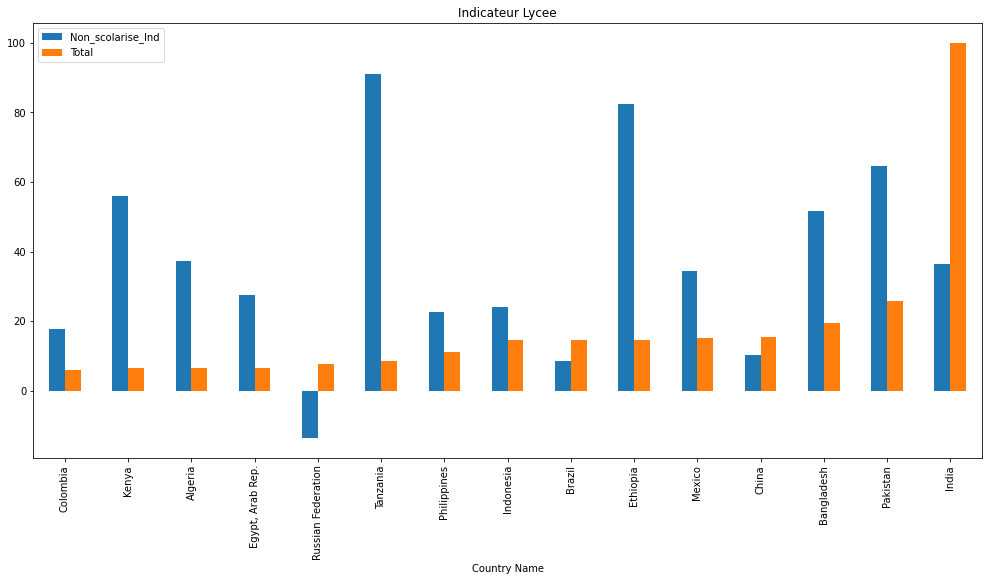

In [129]:
#Ind_lycee=Ind_lycee.reset_index()
#Ind_lycee[Ind_lycee["Total"]>70][["Country Name","Non_scolarise_Ind","Evolution_college_lycee","Ratio_eleve_prof_Ind","Total"]].sort_values(by="Total").plot(kind='bar', x="Country Name", figsize=(17, 8), title="Indicateur Lycee")
Ind_lycee[["Non_scolarise_Ind","Total"]].sort_values(by="Total").tail(15).plot(kind='bar', figsize=(17, 8), title="Indicateur Lycee")

**Mise en place d'indicateur scolaire Université**

In [130]:
Ind_uni=last_ent_uni_ind["last_v"].to_frame()
Ind_uni=Ind_uni.rename({"last_v": "Entre_universite_t"}, axis='columns')
#Ind_uni["Evolution_lycee_universite"]=last_ent_up_ind.astype(float)["last_v"]-Ind_uni["Entre_universite_t"]
Ind_uni["Evolution_lycee_universite_v"]=last_ent_up_ind_v.astype(float)["last_v"]-last_ent_uni_ind_v["last_v"]

#Ind_uni["Ratio_eleve_prof"]=last_ratio_pe_uni_ind["last_v"]
#Ind_uni["Ratio_eleve_prof_Ind"]=Ind_uni["Ratio_eleve_prof"].apply(lambda x: 15*np.log(x-20) if x>20 else 0)

Ind_uni["Non_scolarise_Ind"]=100-Ind_uni["Entre_universite_t"]
Ind_uni["Non_scolarise_Ind_v"]=Ind_uni["Non_scolarise_Ind"]*(last_ent_uni_ind_v["last_v"].astype(int)/Ind_uni["Entre_universite_t"])

Ind_uni["Besoin_eleve"]=(Ind_uni["Evolution_lycee_universite_v"]+Ind_uni["Non_scolarise_Ind_v"])/2
Ind_uni["Total"]=(Ind_uni["Besoin_eleve"]/max(Ind_uni["Besoin_eleve"]))*100 #+Ind_uni["Ratio_eleve_prof_Ind"]
Ind_uni.dropna(axis=0, inplace=True)

In [131]:
#last_ent_up_ind_v.astype(float)["last_v"]

In [132]:
#last_ent_uni_ind_v["last_v"]

In [133]:
Ind_uni.sort_values(by="Total")

Entre_universite_t Evolution_lycee_universite_v  \
Country Name                                                           
United States                   85.7958                 -7.79541e+06   
Russian Federation              80.3941                 -3.76941e+06   
Korea, Rep.                     93.1791                 -1.36424e+06   
Turkey                          94.7323                 -1.06726e+06   
Venezuela, RB                   76.9796                 -1.23067e+06   
Ukraine                          82.305                      -971814   
Argentina                       82.9174                 -1.14675e+06   
Greece                          113.872                      -306405   
Belarus                         87.9407                      -276321   
Australia                       90.3065                      -349359   
Spain                           89.6701                      -301344   
Chile                           88.5773                      -189733   
Ireland                         83.7778                       -63727   
Macao SAR, China                75.5988                       -14116   
Barbados                        65.4322                        -4011   
Iceland                         81.2604                         4052   
Lithuania                       68.5314                       -54194   
Estonia                         69.5504                       -11320   
St. Lucia                       16.7659                         2603   
Cyprus                          60.1012                        -6369   
Slovenia                        82.9264                           95   
Malta                           47.4219                         4202   
Latvia                          67.0397                       -19126   
Mongolia                         68.567                       -58576   
Belize                          23.2903                          336   
New Zealand                     83.9313                     -20760.2   
Austria                         81.5405                     -62784.1   
Luxembourg                      19.4074                        18324   
Brunei Darussalam               30.8448                        23225   
Bahrain                         43.2632                         5199   
Cabo Verde                      21.7078                        11595   
Denmark                          82.787                        -2397   
Norway                          76.6964                       -18349   
Hong Kong SAR, China            68.4755                     -73205.7   
Guyana                          12.4806                        21471   
Uruguay                         55.5663                       -23121   
Mauritius                       36.6676                        29954   
Croatia                         69.0525                        24329   
Finland                         87.2897                        55072   
Bulgaria                        73.9342                         7851   
Albania                           58.11                        -8590   
Macedonia, FYR                  42.0634                        30047   
Moldova                         41.2135                       -30407   
Armenia                         44.3095                        -4280   
Costa Rica                      53.6297                       -56381   
Netherlands                     78.5011                       -96186   
Trinidad and Tobago             11.9512                        27693   
Botswana                        27.5311                         3299   
Swaziland                       5.32888                        21193   
Qatar                           14.5181                        13125   
Georgia                         43.4195                        12690   
Slovak Republic                 52.9235                         9696   
Panama                          38.7393                        -7275   
Israel                          64.7468                      

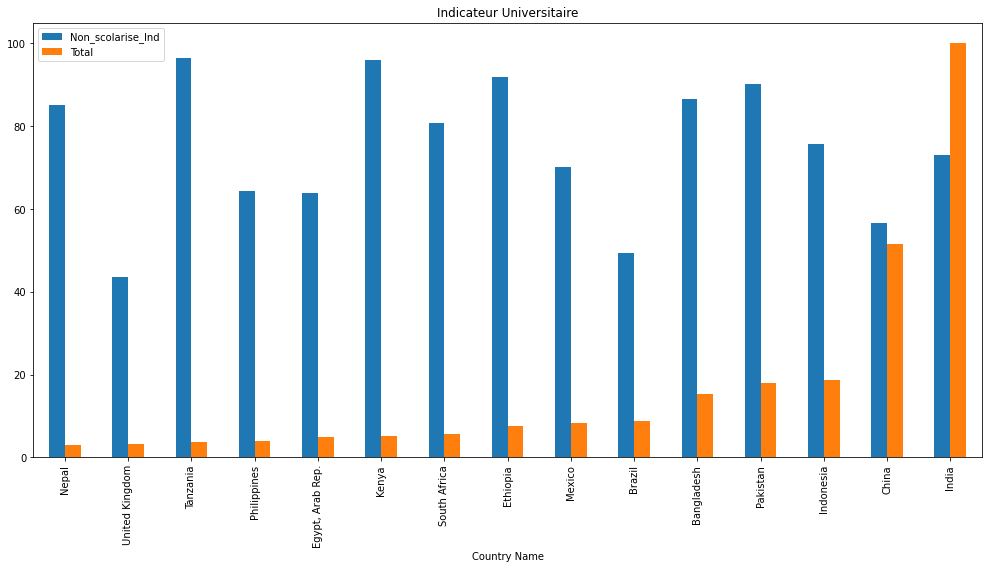

In [134]:
#Ind_uni=Ind_uni.reset_index()
Ind_uni[["Non_scolarise_Ind","Total"]].sort_values(by="Total").tail(15).plot(kind='bar', figsize=(17, 8), title="Indicateur Universitaire")

**Mise en place d'indicateurs finaux**

In [135]:
#Ind_final=Access_ind[['Country Name','Region','2005']]
#evolution_infra.reset_index(inplace=True)
Ind_final=pd.DataFrame(data={'infra_2020_valeur': infra["infra_2020_valeur"], 'infra_2020_taux':infra["infra_2020"] })
#Ind_final=infra[["infra_2020_valeur"]]
#Ind_final["infra_2020_taux"]=infra["infra_2020"]

#Ind_final=Ind_final.rename({"Potentiel_evolution_final_v": "Total_Infra"}, axis='columns')
#Ind_final["Evolution_infra_1995_2010"]=evolution_infra["Pourcentage Evolution"]
#Ind_final["Total_Infra"]=Ind_final[["Acces_infra_2005", "Evolution_infra_1995_2010"]].max(axis=1)
#Ind_final["Total_Infra"]=evolution_infra["Potentiel_evolution_final_p5"]

Ind_final["Total_Scolaire_lycee"]=Ind_lycee["Total"]
Ind_final["Total_Scolaire_uni"]=Ind_uni["Total"]

Ind_final["Total_Final_lycee"]=Ind_final[(Ind_final["infra_2020_taux"]>80) | (Ind_final["infra_2020_valeur"]>80) ]["Total_Scolaire_lycee"]
Ind_final["Total_Final_uni"]=Ind_final[(Ind_final["infra_2020_taux"]>80) | (Ind_final["infra_2020_valeur"]>80) ]["Total_Scolaire_uni"]
Ind_final["Total_Final_lycee_uni"]=(Ind_final["Total_Final_lycee"]+Ind_final["Total_Final_uni"])/2

In [136]:
Ind_final

infra_2020_valeur  infra_2020_taux Total_Scolaire_lycee  \
Country Name                                                                   
Albania                        1.44828        50.275209             0.116653   
Algeria                         23.273        58.370021              6.65488   
Argentina                      26.7156        61.531523              3.10416   
Armenia                        2.94832       101.075423             0.121673   
Australia                      26.5605       111.648938            -0.860228   
Austria                        8.67021       100.429032           -0.0680446   
Azerbaijan                     9.88448       102.436878               1.1681   
Bahrain                        1.24866        91.019896           0.00168602   
Bangladesh                     52.8745        32.800390              19.4849   
Barbados                      0.197521        69.496502           0.00695965   
Belarus                        6.78114        71.458574             0.528115   
Belgium                         10.203        90.498804             -1.54815   
Belize                        0.143485        39.935816             0.062322   
Benin                          2.24885        21.263830              2.01723   
Bolivia                        3.28557        30.635560            -0.158508   
Botswana                       2.02277        91.561252             0.263836   
Brazil                         158.044        76.734508              14.5849   
Brunei Darussalam             0.230546        55.215081           -0.0406534   
Bulgaria                       3.98847        55.565242            -0.186008   
Burkina Faso                   5.21266        28.782351              3.64207   
Burundi                        1.25899        12.343966              1.74244   
Cabo Verde                    0.231397        43.421243            0.0509035   
Cambodia                       19.0192       122.564850              2.42309   
Cameroon                       10.3101        45.151229               3.9012   
Chad                           0.51225         3.656469              2.13022   
Chile                          10.6122        59.744340             -1.24194   
China                          630.401        45.973745              15.5772   
Colombia                       36.4077        75.489788              6.02793   
Congo, Rep.                   0.320222         6.410022             0.745313   
Costa Rica                     3.33567        69.379635             0.305721   
Croatia                        2.55755        60.841936            0.0290734   
Cuba                           6.35645        55.459456          -0.00715639   
Cyprus                         1.10564        95.232498           -0.0072544   
Czech Republic                 8.72138        82.698031             -0.20684   
Denmark                      0.0244161         0.429598            -0.402648   
Dominican Republic             5.08701        48.317063           -0.0540796   
Ecuador                        16.2677       100.764012             0.628464   
Egypt, Arab Rep.               38.6171        41.179198              6.66903   
El Salvador                    2.03081        32.171347             0.745968   
Eritrea                       0.134335         3.002111              1.03393   
Estonia                        1.00838        76.658846           -0.0335361   
Ethiopia                       51.8179        51.883779              14.6299   
Finland                        4.53838        82.824162             -0.86661   
France                         92.3037       138.544120              1.02668   
Gambia, The                    0.61016        30.853721             0.226791   
Georgia                        1.73964        46.800873            0.0216681   
Germany                        94.2922       115.431693                4.738   
Ghana                          17.7435        64.327949              5.16418   
Greece               

In [137]:
Ind_final.dropna(axis=0, inplace=True)

In [138]:
Ind_final.sort_values(by="Total_Final_lycee_uni")

infra_2020_valeur  infra_2020_taux Total_Scolaire_lycee  \
Country Name                                                                   
United Kingdom                 80.1092       123.001053             -7.38005   
Spain                          41.6625        89.697644             -1.17598   
Belgium                         10.203        90.498804             -1.54815   
Australia                      26.5605       111.648938            -0.860228   
Korea, Rep.                    51.4353       100.823973            0.0164931   
Finland                        4.53838        82.824162             -0.86661   
Sweden                         11.9496       121.944949            -0.918603   
Italy                          57.6925        94.997524              -2.4721   
Norway                         5.53413       106.659359            -0.274315   
United States                  314.605        98.039402              3.94887   
Netherlands                    22.3705       132.058098            -0.271483   
New Zealand                    4.22357        91.902653            -0.174824   
Ireland                        5.63269       120.438042           -0.0358412   
Latvia                         2.63163       133.076787           -0.0603913   
Austria                        8.67021       100.429032           -0.0680446   
Iceland                       0.392323       118.592843           -0.0392283   
Hong Kong SAR, China            6.5903        90.207709           -0.0739517   
Macao SAR, China              0.734095       122.157326           0.00128883   
Czech Republic                 8.72138        82.698031             -0.20684   
Cyprus                         1.10564        95.232498           -0.0072544   
Malta                         0.350612        81.183784          -0.00668036   
Luxembourg                    0.700221       122.931243          -0.00230492   
Bahrain                        1.24866        91.019896           0.00168602   
Switzerland                    10.1728       122.823861            -0.192275   
Hungary                        10.7307       109.018479            -0.311288   
Macedonia, FYR                 3.05954       147.142249            0.0693072   
Armenia                        2.94832       101.075423             0.121673   
Moldova                        3.04449        85.661070             0.251927   
Slovak Republic                6.11605       112.763244             0.203801   
Kuwait                          4.3608       110.798396              0.18899   
Botswana                       2.02277        91.561252             0.263836   
Lesotho                        1.76058        80.959213             0.275905   
Romania                        16.4853        83.193948             0.188398   
Japan                          122.717        96.520042            -0.320017   
Ecuador                        16.2677       100.764012             0.628464   
Azerbaijan                     9.88448       102.436878               1.1681   
Kazakhstan                     31.5273       179.702938              1.78575   
France                         92.3037       138.544120              1.02668   
United Arab Emirates           9.34222       102.052743             0.423521   
Cambodia                       19.0192       122.564850              2.42309   
Germany                        94.2922       115.431693                4.738   
Russian Federation             112.341        77.962376              7.58848   
Brazil                         158.044        76.734508              14.5849   
Mexico                         80.4007        63.865360              15.0399   
China                          630.401        45.973745              15.5772   
India                           592.11        45.231900                  100   

                     Total_Scolaire_uni Total_Final_lycee Total_Final_uni  \
Country Name                                                                
United Kingdom            

**Pays à intéressant ou à fort potentiel Lycée**

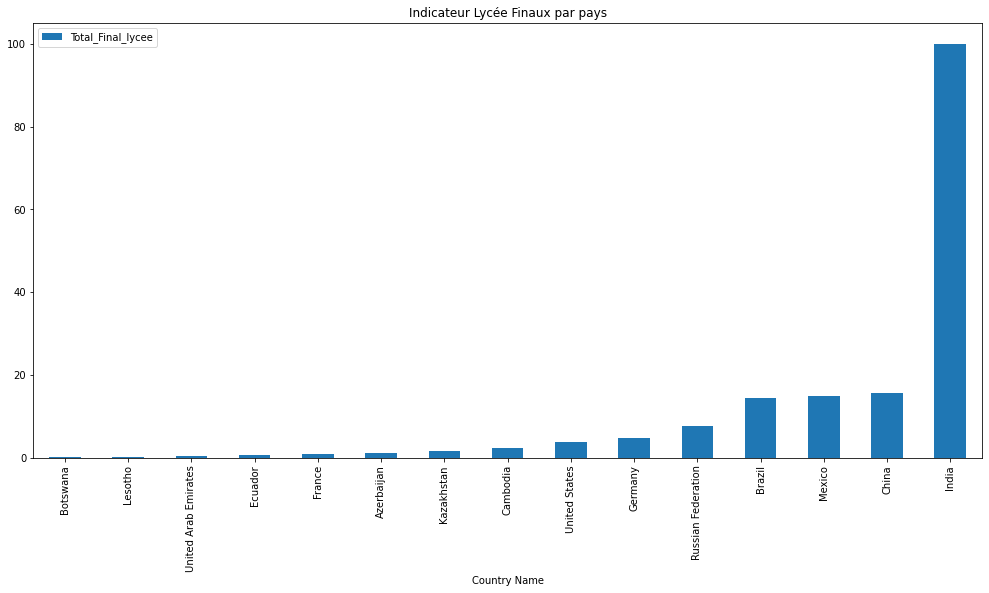

In [139]:
Ind_final.sort_values(by="Total_Final_lycee").tail(15)[[#,"Total_Scolaire_lycee"
                                                        "Total_Final_lycee"]].plot(kind='bar', figsize=(17, 8), title="Indicateur Lycée Finaux par pays")

**Pays à intéressant ou à fort potentiel Université**

In [140]:
Ind_final.sort_values(by="Total_Final_uni").tail(15)

infra_2020_valeur  infra_2020_taux Total_Scolaire_lycee  \
Country Name                                                                   
Kazakhstan                     31.5273       179.702938              1.78575   
Romania                        16.4853        83.193948             0.188398   
Azerbaijan                     9.88448       102.436878               1.1681   
Germany                        94.2922       115.431693                4.738   
Ecuador                        16.2677       100.764012             0.628464   
Cambodia                       19.0192       122.564850              2.42309   
France                         92.3037       138.544120              1.02668   
Italy                          57.6925        94.997524              -2.4721   
Japan                          122.717        96.520042            -0.320017   
United Arab Emirates           9.34222       102.052743             0.423521   
United Kingdom                 80.1092       123.001053             -7.38005   
Mexico                         80.4007        63.865360              15.0399   
Brazil                         158.044        76.734508              14.5849   
China                          630.401        45.973745              15.5772   
India                           592.11        45.231900                  100   

                     Total_Scolaire_uni Total_Final_lycee Total_Final_uni  \
Country Name                                                                
Kazakhstan                     0.527871           1.78575        0.527871   
Romania                        0.667574          0.188398        0.667574   
Azerbaijan                     0.692826            1.1681        0.692826   
Germany                        0.892839             4.738        0.892839   
Ecuador                        0.999042          0.628464        0.999042   
Cambodia                        1.36832           2.42309         1.36832   
France                          1.38535           1.02668         1.38535   
Italy                            1.8555           -2.4721          1.8555   
Japan                           1.85892         -0.320017         1.85892   
United Arab Emirates            2.17814          0.423521         2.17814   
United Kingdom                  3.30855          -7.38005         3.30855   
Mexico                          8.38496           15.0399         8.38496   
Brazil                          8.82618           14.5849         8.82618   
China                           51.5173           15.5772         51.5173   
India                               100               100             100   

                     Total_Final_lycee_uni  
Country Name                                
Kazakhstan                         1.15681  
Romania                           0.427986  
Azerbaijan                        0.930461  
Germany                            2.81542  
Ecuador                           0.813753  
Cambodia                           1.89571  
France                             1.20601  
Italy                            -0.308299  
Japan                             0.769451  
United Arab Emirates               1.30083  
United Kingdom                    -2.03575  
Mexico                             11.7125  
Brazil                             11.7055  
China                              33.5472  
India                                  100

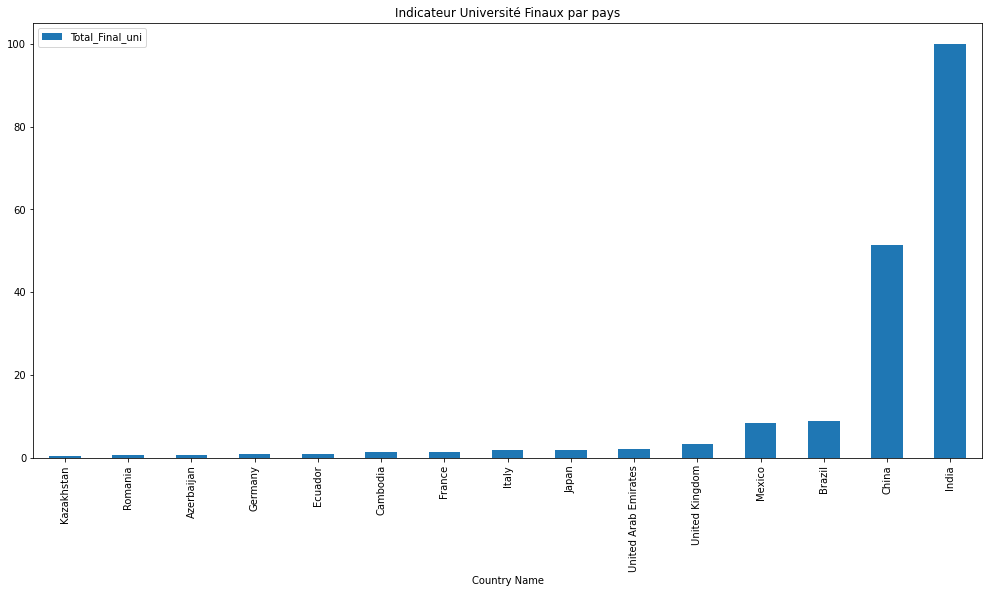

In [141]:
Ind_final.sort_values(by="Total_Final_uni").tail(15)[[#,"Total_Scolaire_uni"
                                                      "Total_Final_uni"]].plot(kind='bar', figsize=(17, 8), title="Indicateur Université Finaux par pays")

**Pays à intéressant ou à fort potentiel Final**

In [142]:
Ind_final.sort_values(by="Total_Final_lycee_uni").tail(15)

infra_2020_valeur  infra_2020_taux Total_Scolaire_lycee  \
Country Name                                                                   
Lesotho                        1.76058        80.959213             0.275905   
Romania                        16.4853        83.193948             0.188398   
Japan                          122.717        96.520042            -0.320017   
Ecuador                        16.2677       100.764012             0.628464   
Azerbaijan                     9.88448       102.436878               1.1681   
Kazakhstan                     31.5273       179.702938              1.78575   
France                         92.3037       138.544120              1.02668   
United Arab Emirates           9.34222       102.052743             0.423521   
Cambodia                       19.0192       122.564850              2.42309   
Germany                        94.2922       115.431693                4.738   
Russian Federation             112.341        77.962376              7.58848   
Brazil                         158.044        76.734508              14.5849   
Mexico                         80.4007        63.865360              15.0399   
China                          630.401        45.973745              15.5772   
India                           592.11        45.231900                  100   

                     Total_Scolaire_uni Total_Final_lycee Total_Final_uni  \
Country Name                                                                
Lesotho                         0.20805          0.275905         0.20805   
Romania                        0.667574          0.188398        0.667574   
Japan                           1.85892         -0.320017         1.85892   
Ecuador                        0.999042          0.628464        0.999042   
Azerbaijan                     0.692826            1.1681        0.692826   
Kazakhstan                     0.527871           1.78575        0.527871   
France                          1.38535           1.02668         1.38535   
United Arab Emirates            2.17814          0.423521         2.17814   
Cambodia                        1.36832           2.42309         1.36832   
Germany                        0.892839             4.738        0.892839   
Russian Federation             -1.95658           7.58848        -1.95658   
Brazil                          8.82618           14.5849         8.82618   
Mexico                          8.38496           15.0399         8.38496   
China                           51.5173           15.5772         51.5173   
India                               100               100             100   

                     Total_Final_lycee_uni  
Country Name                                
Lesotho                           0.241978  
Romania                           0.427986  
Japan                             0.769451  
Ecuador                           0.813753  
Azerbaijan                        0.930461  
Kazakhstan                         1.15681  
France                             1.20601  
United Arab Emirates               1.30083  
Cambodia                           1.89571  
Germany                            2.81542  
Russian Federation                 2.81595  
Brazil                             11.7055  
Mexico                             11.7125  
China                              33.5472  
India                                  100

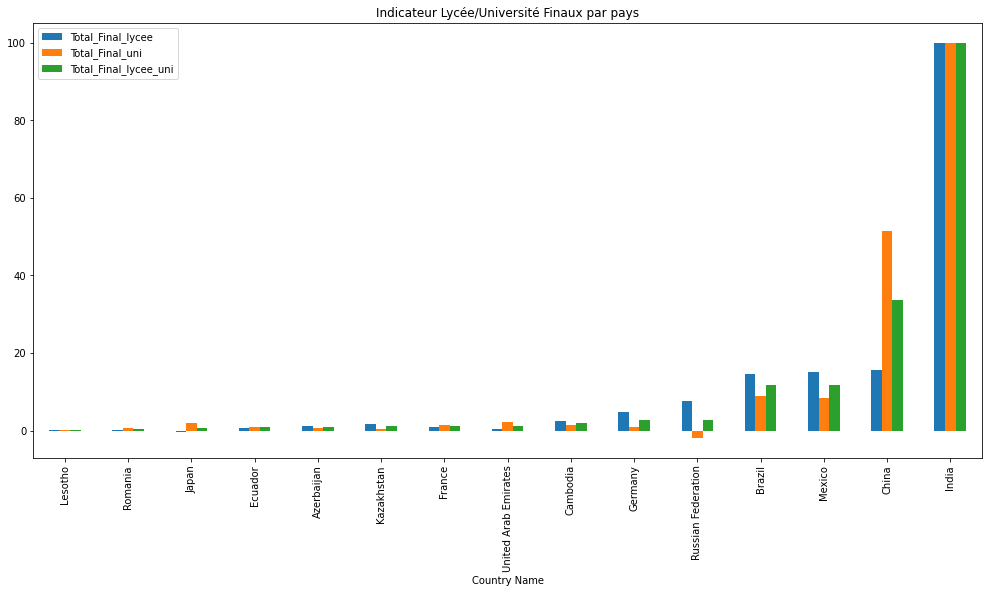

In [143]:
Ind_final.sort_values(by="Total_Final_lycee_uni").tail(15)[["Total_Final_lycee","Total_Final_uni","Total_Final_lycee_uni"]].plot(kind='bar', figsize=(17, 8), title="Indicateur Lycée/Université Finaux par pays")

In [144]:
Pays_fort_potentiel=Ind_final.sort_values(by="Total_Final_lycee_uni").tail(15)

In [145]:
#Ind_uni[Ind_uni["Country Name"].isin(Pays_fort_potentiel)]